# Introduction


## Challenge Large Scale Machine Learning

### Authors: 
#### Pavlo Mozharovskyi (pavlo.mozharovskyi@telecom-paristech.fr), Umut Şimşekli (umut.simsekli@telecom-paristech.fr)


### Fusion of algorithms for face recognition

The increasingly ubiquitous presence of biometric solutions and face recognition in particular in everyday life requires their adaptation for practical scenario. In the presence of several possible solutions, and if global decisions are to be made, each such single solution can be far less efficient than tailoring them to the complexity of an image.

In this challenge, the goal is to build a fusion of algorithms in order to construct the best suited solution for comparison of a pair of images. This fusion will be driven by qualities computed on each image.

Comparing of two images is done in two steps. 1st, a vector of features is computed for each image. 2nd, a simple function produces a vector of scores for a pair of images. The goal is to create a function that will compare a pair of images based on the information mentioned above, and decide whether two images belong to the same person.

You are provided a label set of training data and a test set without labels. You should submit a .csv file with labels for each entry of this test set.

# The properties of the dataset:


### Training data: 


The training set consist of two files, **xtrain_challenge.csv** and **xtest_challenge.csv**.

File **xtrain_challenge.csv** contains one observation per row which contains following entries based on a pair of images, A and B say:
 * columns 1-14 - 14 qualities on image A;
 * columns 15-28 - 14 qualities on image B;
 * columns 29-36 - 8 matching scores between A and B.

File **ytrain_challenge.csv** contains one line with each entry corresponding to one observation in **xtrain_challenge.csv**, maintaining the order, and has '1' if a pair of images belong to the same person and '0' otherwise.

There are in total 3.196.465 training observations.

### Test data:

File **xtest_challenge.csv** has the same structure as file **xtrain_challenge.csv**.

There are in total 1.598.219 test observations.

## The performance criterion¶

The performance criterion is the **prediction accuracy** on the test set, which is a value between 0 and 1, the higher the better.

# Data Set

Training data, input (file **xtrain_challenge.csv**): https://www.dropbox.com/s/myvvtmw61eg5gk7/xtrain_challenge.csv

Training data, output (file **ytrain_challenge.csv**): https://www.dropbox.com/s/cleumxob0dfzre4/ytrain_challenge.csv

Test data, input (file **xtest_challenge.csv**): https://www.dropbox.com/s/bfrx8b4mqythm4q/xtest_challenge.csv

In [1]:
%matplotlib inline
# Basic librairies
import sys
import os
import math
import numpy as np
import pandas as pd
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
import random

# sklearn
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Classifiers
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier
from xgboost import XGBClassifier

# Keras
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import History
from keras.optimizers import Adam, SGD, Adamax
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import one_hot
from keras.layers import Flatten

# Usefull librairies
import time
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Exploration des données

In [4]:
Xtrain = pd.read_csv('xtrain_challenge.csv', nrows=100000)
ytrain = pd.read_csv('ytrain_challenge.csv',nrows=100000)
Xtest = pd.read_csv('xtest_challenge.csv',nrows=10000)
print(Xtrain.shape, ytrain.shape, Xtest.shape)

(100000, 36) (100000, 1) (10000, 36)


In [5]:
Xtrain.head()

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,fB13,fB14,s1,s2,s3,s4,s5,s6,s7,s8
0,3.77,1.00,1.0,41,1.0,0.0,0.0,-0.17,0.03,0.00,...,0.04,271.80,2464.1,2117.2,1760.6,2241.3,1900.3,1462.8,2344.9,1949.8
1,1.47,0.01,0.0,62,1.0,0.0,0.0,0.30,0.02,-0.01,...,0.01,157.15,3975.9,2640.9,2672.6,4233.8,3357.9,2224.0,3341.1,3611.5
2,4.93,1.00,0.0,21,1.0,0.0,0.0,0.00,0.16,0.00,...,0.07,283.33,3401.1,2644.3,2514.2,3551.3,3019.7,3414.7,2763.6,3252.2
3,3.89,1.00,0.0,20,1.0,0.0,0.0,-0.35,0.09,-0.01,...,0.10,298.40,2418.6,2659.6,2742.1,3422.4,2602.6,2784.0,2697.4,2505.1
4,3.15,0.00,0.0,28,1.0,0.0,0.0,0.08,-0.08,-0.01,...,0.01,248.69,2309.1,2164.0,1755.6,2377.4,1994.6,2147.6,1902.9,2599.5


In [18]:
Xtrain.describe()

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,fB13,fB14,s1,s2,s3,s4,s5,s6,s7,s8
count,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,...,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06
mean,3.123656e+00,7.200140e-01,8.895844e-02,2.938227e+01,9.112188e-01,4.165448e-03,8.456615e-02,1.323673e-01,2.970159e-02,-2.833317e-04,...,-4.888641e-03,2.477718e+02,3.874350e+03,2.434998e+03,4.200151e+03,4.242067e+03,3.488791e+03,3.399066e+03,3.509614e+03,3.745971e+03
std,1.618458e+00,4.224322e-01,2.824698e-01,9.793075e+00,2.757797e-01,4.433567e-02,2.729676e-01,4.159110e-01,1.279389e-01,2.096133e-02,...,5.770911e-02,1.221232e+02,2.063822e+03,2.272729e+02,2.954367e+03,2.127659e+03,1.360081e+03,1.363354e+03,1.066627e+03,1.548290e+03
min,-4.500000e-01,0.000000e+00,0.000000e+00,1.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-2.550000e+00,-3.030000e+00,-3.000000e-01,...,-4.200000e-01,-3.087900e+02,1.212700e+03,1.511400e+03,7.218000e+02,1.133800e+03,6.682000e+02,7.200000e+02,1.358000e+03,7.107000e+02
25%,1.950000e+00,2.500000e-01,0.000000e+00,2.200000e+01,1.000000e+00,0.000000e+00,0.000000e+00,-2.000000e-02,-2.000000e-02,0.000000e+00,...,-3.000000e-02,2.214200e+02,2.420300e+03,2.296300e+03,2.086200e+03,2.735400e+03,2.457200e+03,2.335000e+03,2.742600e+03,2.620100e+03
50%,3.390000e+00,1.000000e+00,0.000000e+00,2.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e-02,0.000000e+00,...,0.000000e+00,2.766400e+02,3.062600e+03,2.439800e+03,3.073300e+03,3.402000e+03,3.063300e+03,2.999800e+03,3.151800e+03,3.218800e+03
75%,4.380000e+00,1.000000e+00,0.000000e+00,3.400000e+01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e-01,8.000000e-02,1.000000e-02,...,2.000000e-02,3.216600e+02,4.442500e+03,2.589300e+03,5.143800e+03,4.898800e+03,4.406800e+03,4.375500e+03,3.926300e+03,4.396900e+03
max,7.940000e+00,1.000000e+00,1.000000e+00,7.400000e+01,1.000000e+00,1.000000e+00,1.000000e+00,2.500000e+00,7.600000e-01,2.600000e-01,...,4.400000e-01,4.814200e+02,1.204420e+04,3.035900e+03,1.666650e+04,1.181290e+04,7.731000e+03,7.580100e+03,6.949500e+03,8.524900e+03


## Visualisations

### Sur les X

In [23]:
# Concaténation du Xtrain et y 
concat = pd.concat(axis=1, objs=[Xtrain,ytrain])
concat_1 = concat[concat.y==1]
concat_0 = concat[concat.y==0]

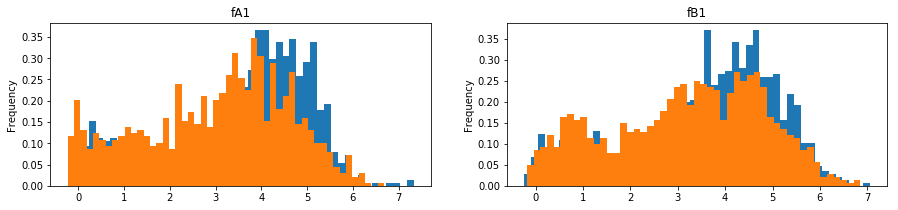

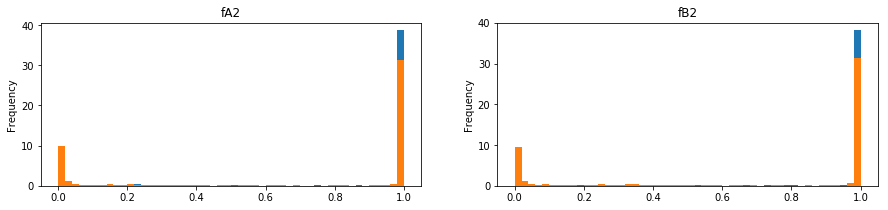

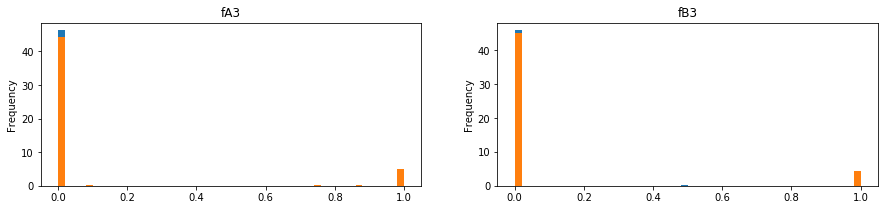

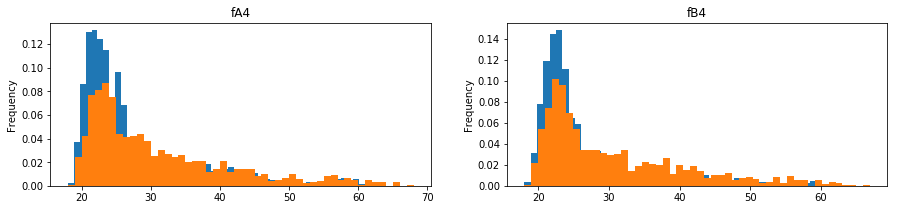

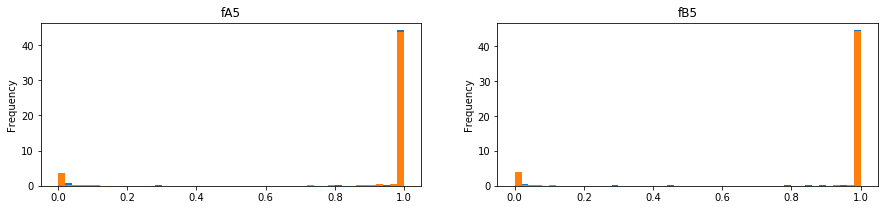

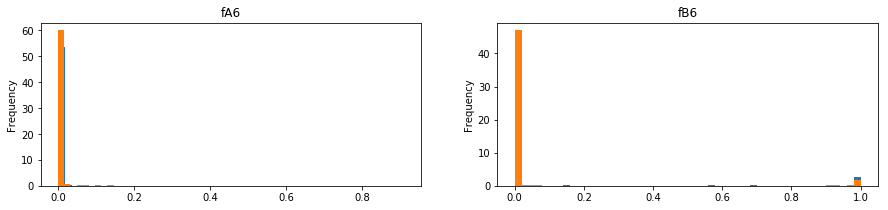

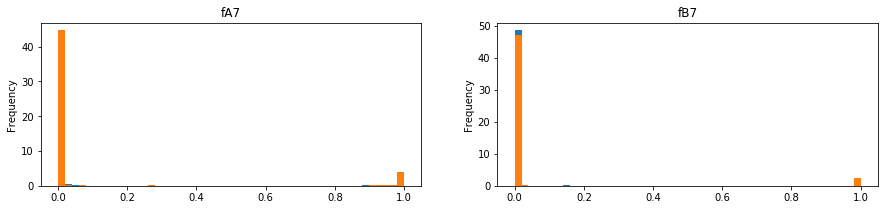

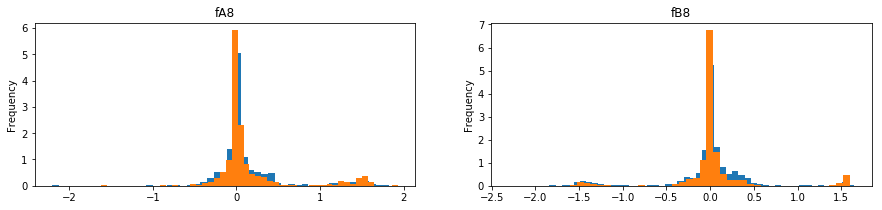

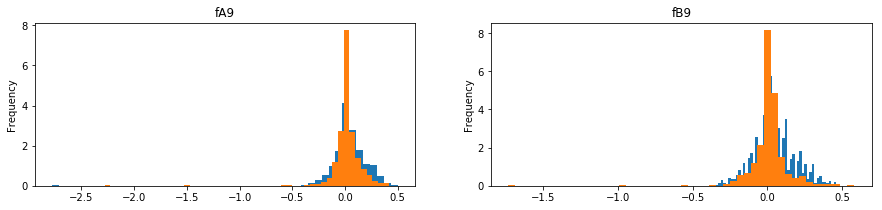

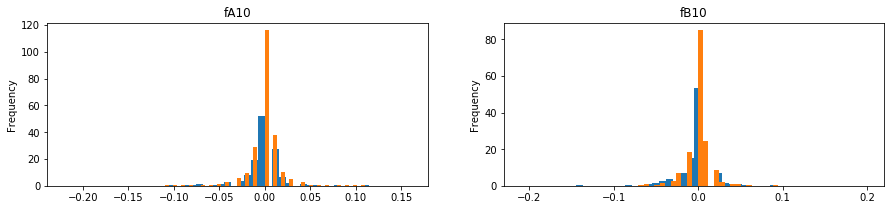

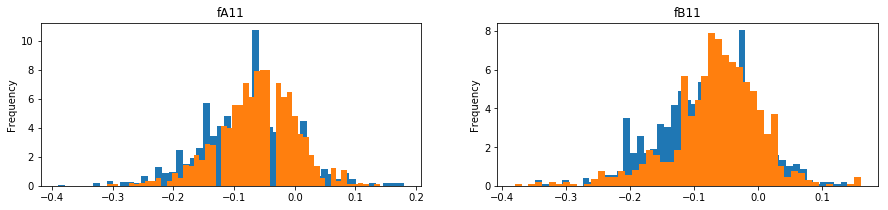

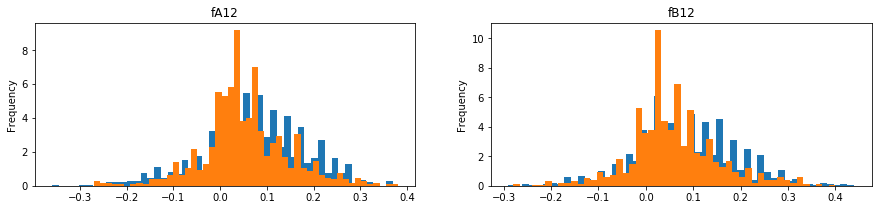

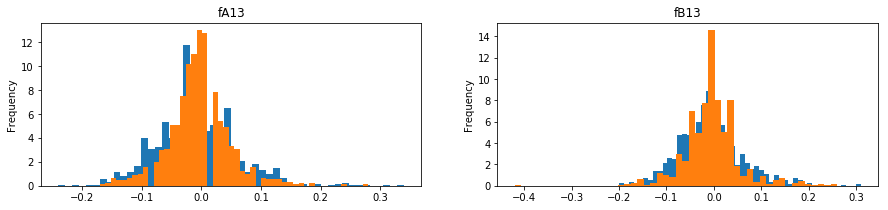

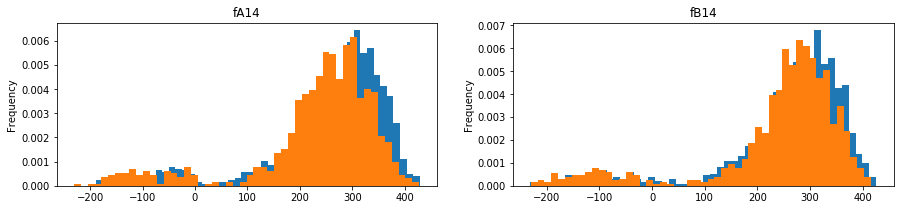

In [28]:
# Visualisation de la répartition de chaque feature du train concernant la qualité des images
for i in range(0,14):
    plt.figure(figsize=(15,3))
    plt.subplot(1,2,1)
    concat_1.iloc[:1000,i].plot.hist(bins=50, density=True)
    concat_0.iloc[:1000,i].plot.hist(bins=50, density=True)
    plt.title(f'fA{i+1}')
    plt.grid(False)
    plt.subplot(1,2,2)
    concat_1.iloc[:1000,i+14].plot.hist(bins=50, density=True)
    concat_0.iloc[:1000,i+14].plot.hist(bins=50, density=True)
    plt.title(f'fB{i+1}')
    plt.grid(False)
    plt.show()   

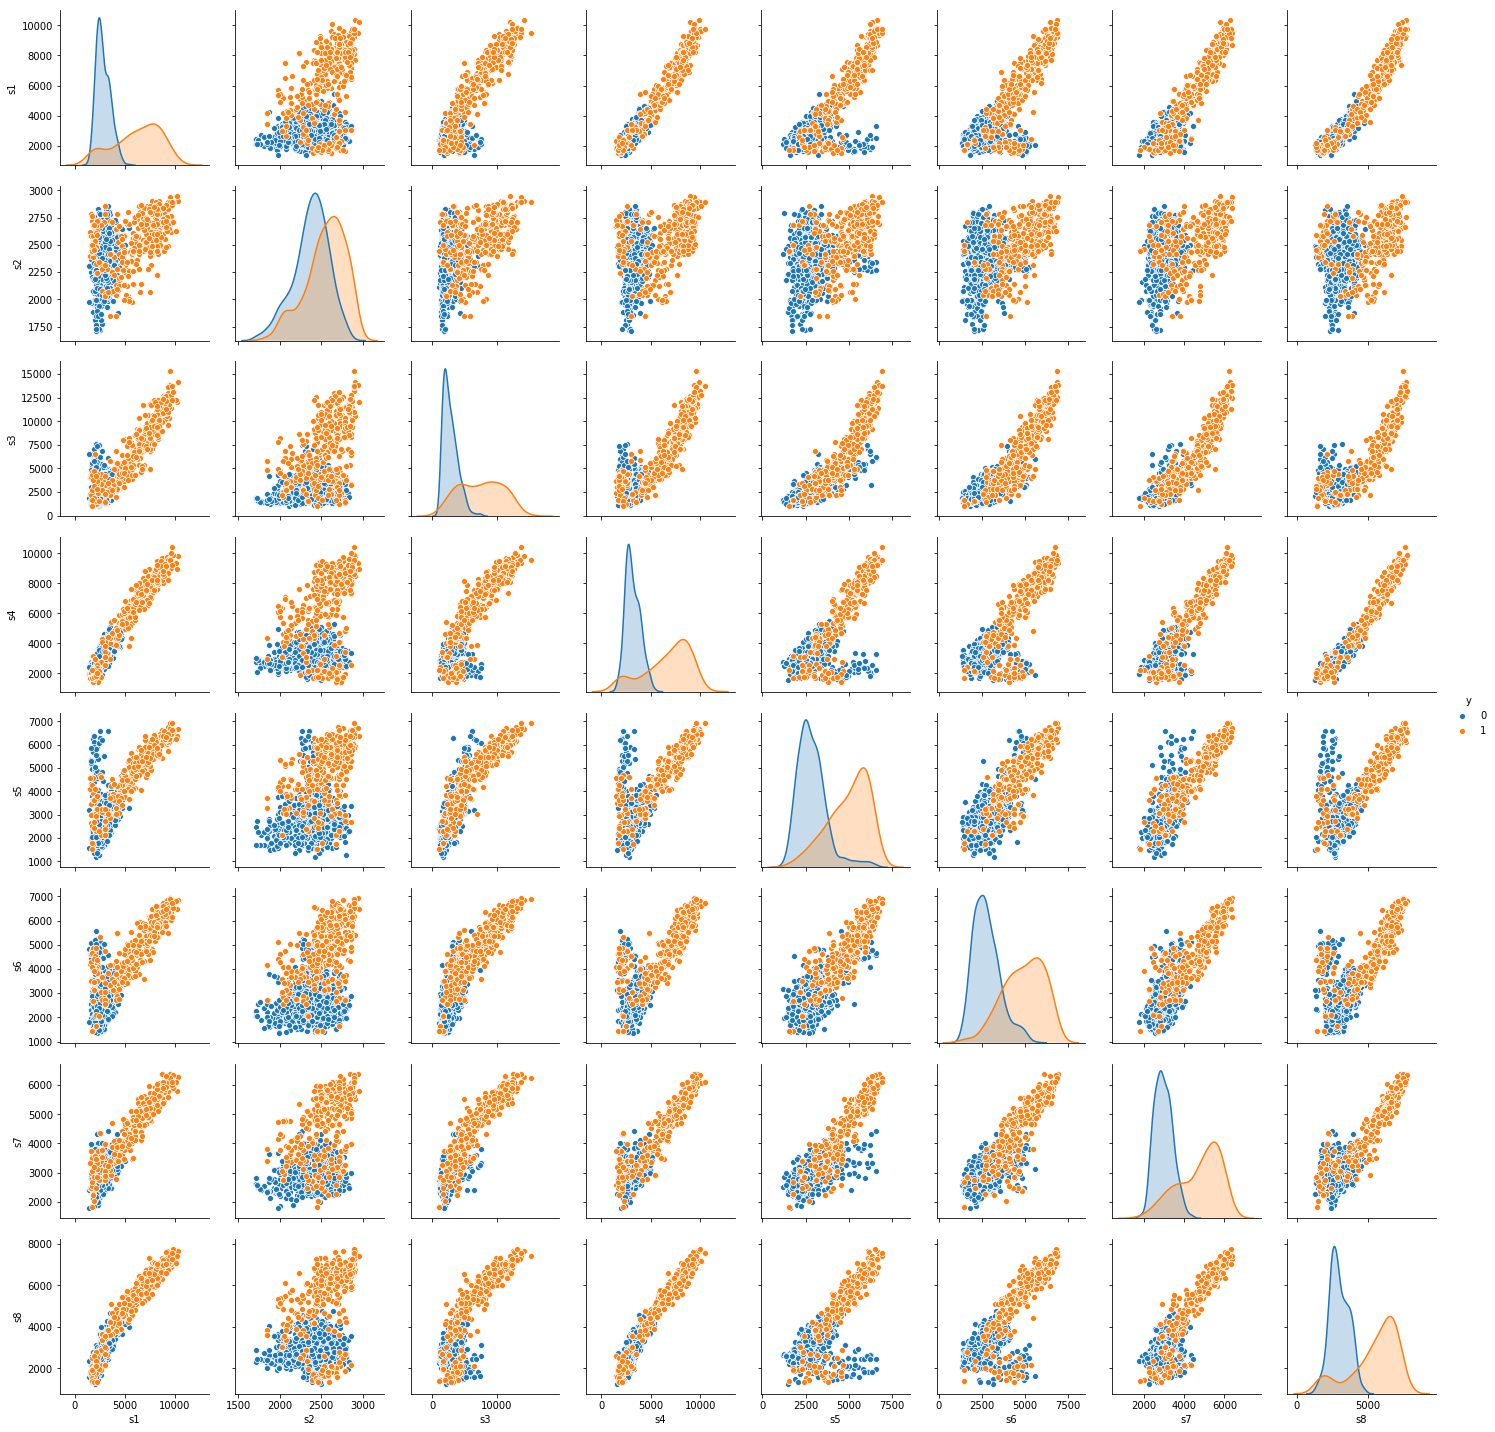

In [14]:
# Visualisation de la répartition de chaque feature du train concernant le matching scores entre les images:
sns.pairplot(data=concat.iloc[:1000,:], vars=['s1','s2','s3','s4','s5','s6','s7','s8'] ,hue='y')
plt.show()

Il n'y a pas d'information particulières à tirer de la répartion des features.

### Sur les Y

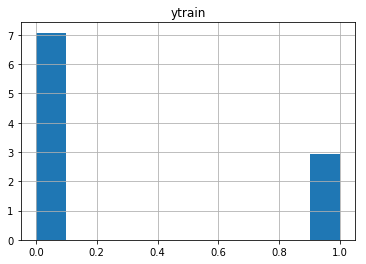

In [58]:
ytrain.iloc[:10000,:].hist(figsize=(6,4), density=True)
plt.title('ytrain')
plt.show()

On constate que le set est très déséquilibré car il a que 30% de 1 et 70% de zéro. On prendra soin lors du split des donner des conserver cette répartion avec le paramètre 'stratify'.

## ClusterMap et Corrélation

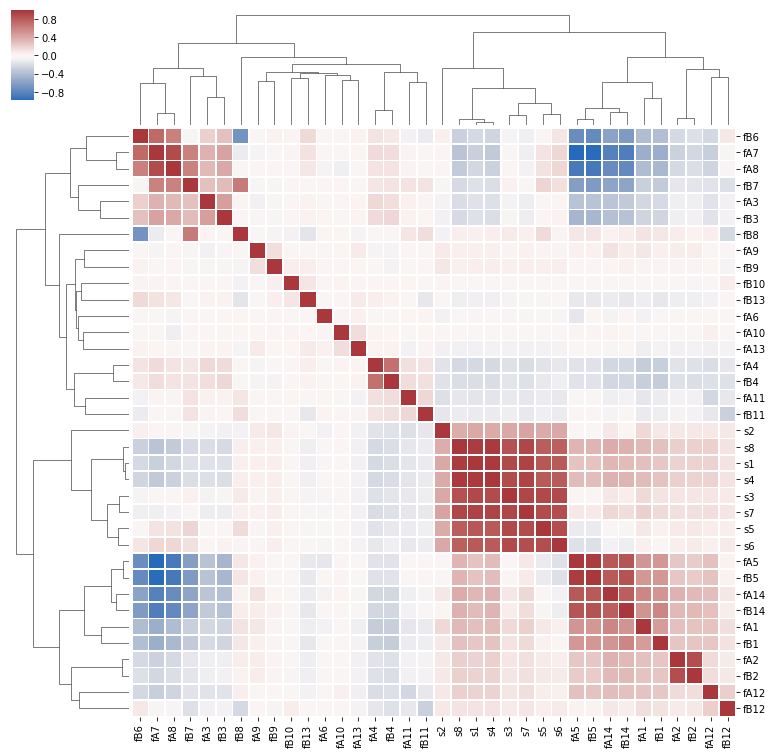

In [22]:
sns.clustermap(Xtrain.iloc[:10000,:].corr(), center=0, cmap="vlag",linewidths=.75, figsize=(13, 13))
plt.show()

On constate que certaines features sont très fortement corrélés. Nous réduirons la dimension par la suite.

## Etude du Test et du Train conjointement

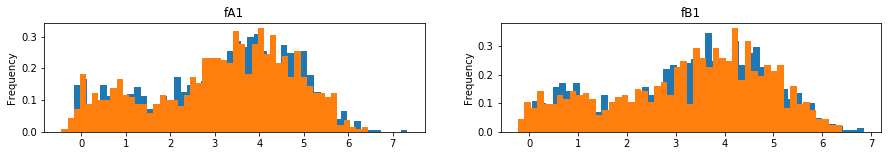

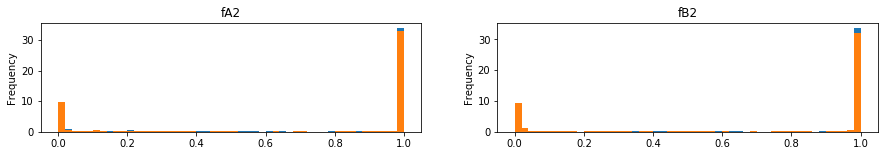

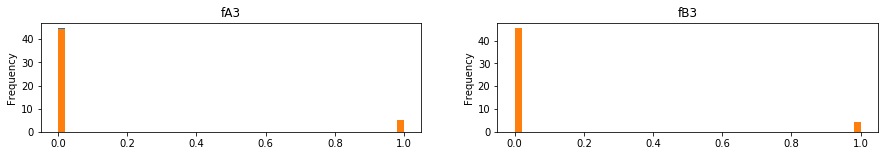

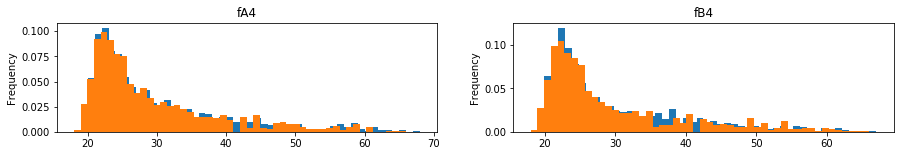

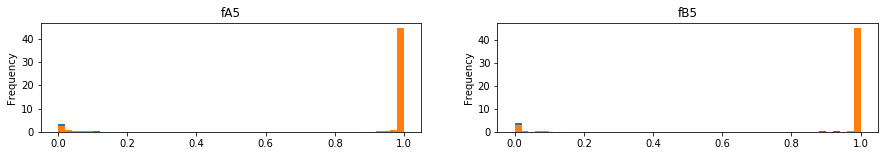

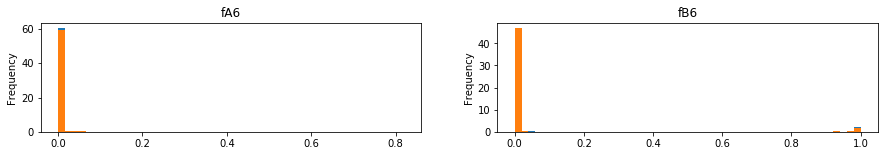

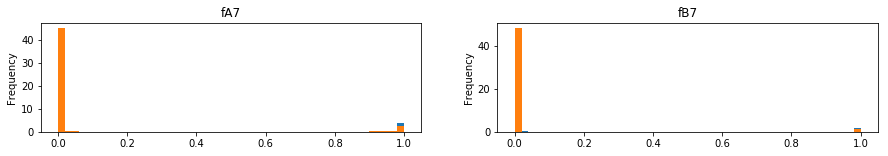

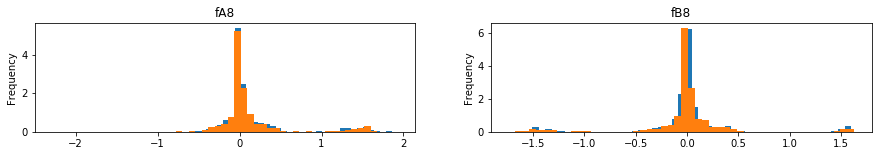

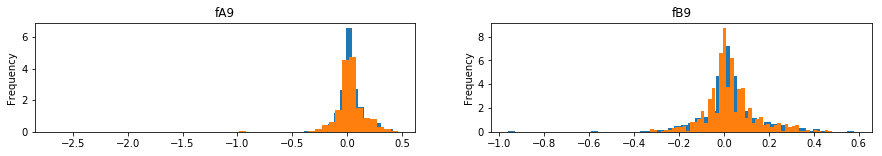

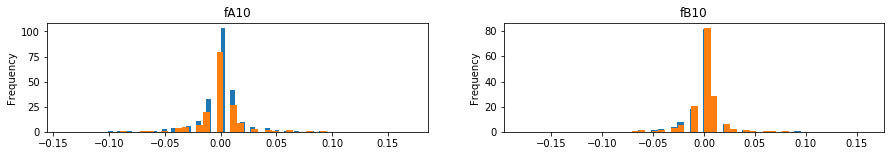

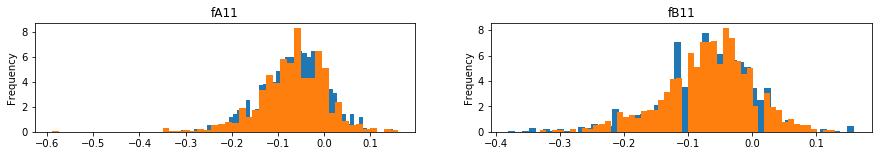

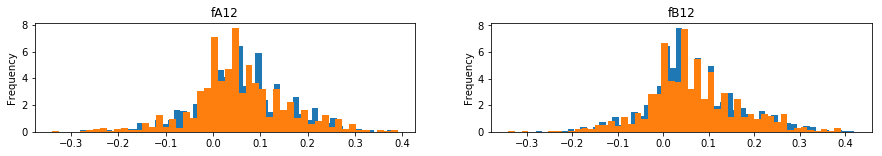

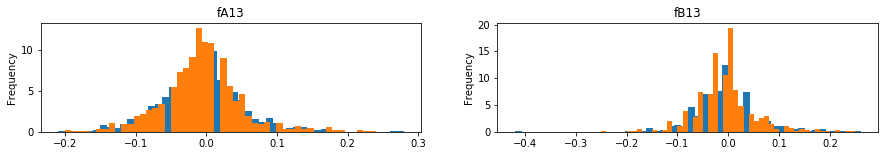

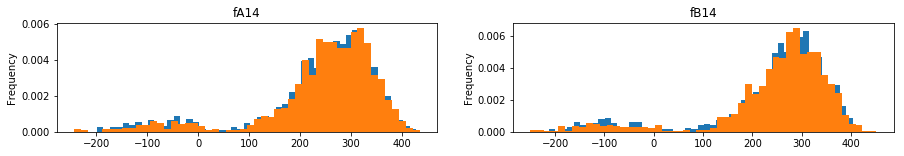

In [29]:
# Superposition des features qualité d'imange du Train et du Test:
for i in range(0,14):
    plt.figure(figsize=(15,2))
    plt.subplot(1,2,1)
    Xtrain.iloc[:1000,i].plot.hist(bins=50, density=True)
    Xtest.iloc[:1000,i].plot.hist(bins=50, density=True)
    plt.title(f'fA{i+1}')
    plt.grid(False)
    plt.subplot(1,2,2)
    Xtrain.iloc[:1000,i+14].plot.hist(bins=50, density=True)
    Xtest.iloc[:1000,i+14].plot.hist(bins=50, density=True)
    plt.title(f'fB{i+1}')
    plt.grid(False)
    plt.show()   

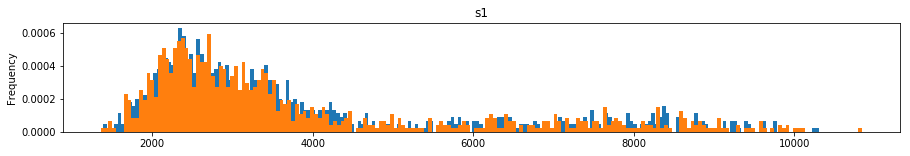

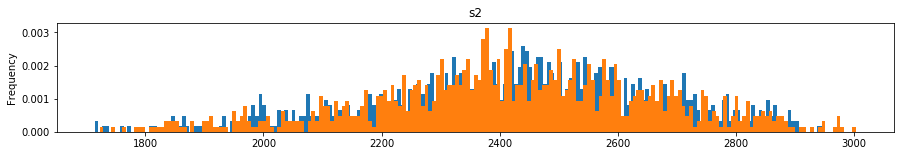

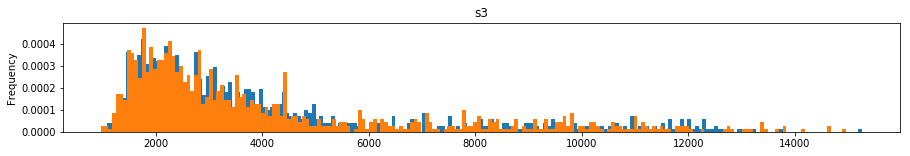

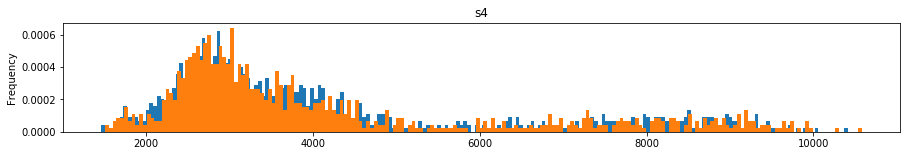

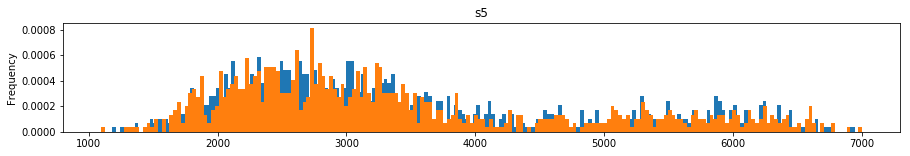

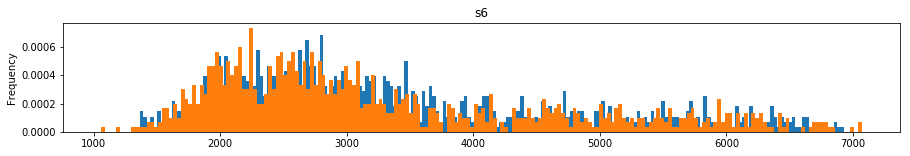

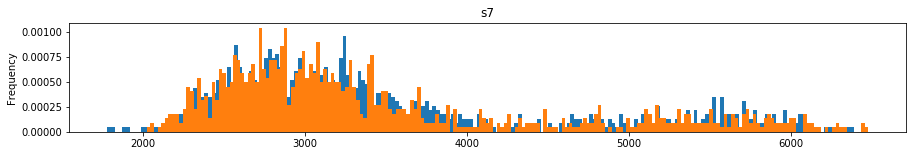

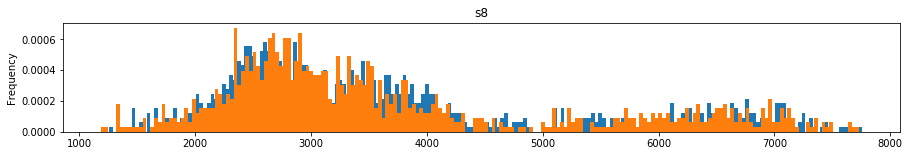

In [36]:
# superposition du matching score du Test et du Train:
for i in range(28,36):
    plt.figure(figsize=(15,2))
    Xtrain.iloc[:1000,i].plot.hist(bins=200, density=True)
    Xtest.iloc[:1000,i].plot.hist(bins=200, density=True)
    plt.title(f's{i-27}')
    plt.show()   

On constate que le train et le test se superposent assez bien ce qui laisse supposer que des données du train sont dans le test.
Nous allons vérifier cette suposition. 

In [90]:
data_set = pd.concat(objs=[Xtrain, Xtest])
A = data_set.iloc[:,:14]
B = data_set.iloc[:,14:28]
s = data_set.iloc[:,28:]
print(A.shape, B.shape, s.shape)

(4794684, 14) (4794684, 14) (4794684, 8)


### Création de features

In [92]:
# Création d'une clé unique par combinaison de feature:
A['key_A'] = ''
B['key_B'] = ''
for i in np.arange(A.shape[1]-1):
    A['key_A'] += A.iloc[:,i].astype(str)
    B['key_B'] += B.iloc[:,i].astype(str)

In [93]:
# Hashage de cette clé pour avoir un nombre entier:
A['hash_key_A'] = A.key_A.apply(lambda x: hash(x)).mod(100000000000)
B['hash_key_B'] = B.key_B.apply(lambda x: hash(x)).mod(100000000000)
A.drop(columns='key_A', inplace=True)
B.drop(columns='key_B', inplace=True)

In [94]:
A.head()

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,fA11,fA12,fA13,fA14,hash_key_A
0,3.77,1.00,1.0,41,1.0,0.0,0.0,-0.17,0.03,0.00,-0.02,0.01,-0.01,201.59,54274518629
1,1.47,0.01,0.0,62,1.0,0.0,0.0,0.30,0.02,-0.01,-0.07,0.09,-0.06,179.02,34054324343
2,4.93,1.00,0.0,21,1.0,0.0,0.0,0.00,0.16,0.00,-0.13,0.09,-0.05,374.03,65833072118
3,3.89,1.00,0.0,20,1.0,0.0,0.0,-0.35,0.09,-0.01,-0.06,0.21,0.03,320.16,71819469861
4,3.15,0.00,0.0,28,1.0,0.0,0.0,0.08,-0.08,-0.01,-0.13,0.08,-0.02,162.15,75335200464


In [95]:
# Création des nouveaux set de données avec la clé hash :
data_set = pd.concat(axis=1, objs=[A, B, s], sort=False)
train = data_set.iloc[:Xtrain.shape[0],:]
test = data_set.iloc[Xtrain.shape[0]:,:]
trainy = train.join(ytrain)

### Analyse des images en commun entre A et B et Test et Train

In [63]:
# Nombre d'images uniques dans le train:
train[['hash_key_A','hash_key_B']].nunique()

hash_key_A    81250
hash_key_B    62459
dtype: int64

In [64]:
# Nombre d'images uniques dans le test:
test[['hash_key_A','hash_key_B']].nunique()

hash_key_A    80895
hash_key_B    62244
dtype: int64

In [65]:
# Nombre d'images uniques dans le data set global:
data_set[['hash_key_A','hash_key_B']].nunique()

hash_key_A    81260
hash_key_B    62503
dtype: int64

On constate qu'il n'y a que 80.000 images différentes environ dans la catégorie A et environ 62.000 différentes dans la catégorie B. De plus les images du train sont quasiment toutes les mêmes que celle du test.

In [77]:
# % d'images du d'images A du test présentent dans les images A du train :
f'{(test[test.hash_key_A.isin(train.hash_key_A)].shape[0]/test.shape[0])*100:.6f}%'

'99.997497%'

In [78]:
# % d'images du d'images B du test présentent dans les images B du train :
f'{(test[test.hash_key_B.isin(train.hash_key_B)].shape[0]/test.shape[0])*100:.6f}%'

'99.994994%'

In [79]:
# Train : % d'images A présentent dans les images B : 
f'{(trainy[trainy.hash_key_B.isin(trainy.hash_key_A)].shape[0]/trainy.shape[0])*100:.4f}%'

'54.4273%'

In [80]:
# Test : % d'image de A présentent dans B 
f'{(test[test.hash_key_A.isin(test.hash_key_B)].shape[0]/test.shape[0])*100:.4f}%'

'54.4431%'

In [81]:
common_row = test.merge(train)

In [83]:
common_row.shape

(16891, 30)

On constate que ce sont les mêmes images présentent dans le train et dans le test. De plus il y environ 54% des images de A qui sont dans B. Seulement les combinaisons d'image A et B changent. De plus on constate qu'il y a aussi 16.891 observations identiques dans le train et dans le test.

# Reduction de dimension  : PCA

In [96]:
# Fit le model à la matrice Xtrain :
pca = PCA(svd_solver='auto')
pca.fit(train)

# # Valeurs propres de la matrice cov(X_train) triées par ordre décroissant :
v_propres = pd.DataFrame(pca.explained_variance_)

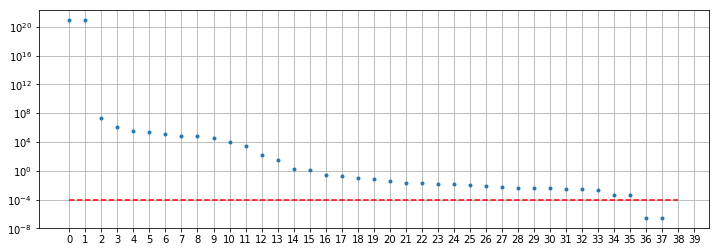

In [126]:
plt.figure(figsize=(12,4))
plt.grid()
plt.xticks(np.arange(0, 40, 1))
plt.yscale(value="log")
plt.plot(v_propres.abs().values,'.')
plt.hlines(y=0.0001, xmax=38, xmin=0, linestyles='--', colors='r')

In [116]:
# Transformation du train et du test ne gardant que les 36 premières features:
pca = PCA(n_components=36, svd_solver='auto')
train_pca = pd.DataFrame(pca.fit_transform(train))
test_pca = pd.DataFrame(pca.fit_transform(test))

In [106]:
train_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,-1.867860e+09,2.401880e+10,-4659.304616,-213.030010,-917.402086,151.454206,471.210142,-303.129983,187.098277,253.778923,...,-0.006157,0.048565,0.006613,0.074925,-0.017448,0.003215,0.019048,-0.014962,-0.002711,-0.008353
1,-8.587390e+09,-2.933059e+10,-1271.066371,-1212.599165,44.778211,716.663094,200.225948,-116.766882,227.450992,-199.422992,...,-0.005866,-0.000703,-0.013647,0.001782,0.014683,-0.024128,0.043740,0.013704,0.000464,-0.018831
2,8.504407e+09,2.998654e+10,-1958.428022,-342.875218,583.821812,-270.199664,235.977581,-297.125296,-289.507375,-297.916217,...,-0.113435,-0.008379,0.055367,0.024990,-0.005991,0.012965,0.082067,0.001182,-0.002228,-0.003045
3,1.453771e+10,3.059373e+10,-2805.482421,184.052886,-172.079007,-241.008319,-335.322441,-462.260748,210.532404,-301.052740,...,0.062446,-0.089068,-0.020344,0.011085,-0.017399,0.115975,0.056593,-0.019556,0.020157,-0.007768
4,2.058492e+10,2.154647e+10,-4365.702033,-216.454975,-476.677334,-222.634543,143.268310,-277.784221,-573.368428,76.493797,...,0.055405,-0.009731,0.059117,-0.022758,-0.017797,-0.012985,0.032985,-0.002349,0.006489,-0.001330


Après de nombreux test sur différents algo, la PCA ne m'a pas permis d'améliorer mon score au challenge. Pour cette raison je continuerai pas à la PCA dans ce rapport.

# Split du data set

In [11]:
seed = 42
test_size = 0.3

In [12]:
# On utilise stratify pour conserver les proportions de 0 et 1 dans les splits
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=test_size, random_state=seed, stratify = ytrain)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(70000, 36) (70000, 1) (30000, 36) (30000, 1)


# Standadisation des données : 

In [13]:
# Standardize split data set
scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train))
X_test_std = pd.DataFrame(scaler.transform(X_test))

In [6]:
# Standardize full data set
scaler = StandardScaler()
Xtrain_std = pd.DataFrame(scaler.fit_transform(Xtrain))
Xtest_std = pd.DataFrame(scaler.transform(Xtest))

# Models

In [143]:
n_estimators = 10
raw = 10000

### SVM

In [144]:
svm = SVC()
svm.fit(X_train.iloc[:raw,:].values, y_train.iloc[:raw].values.ravel())
model_1 = svm.score(X_test.values, y_test.values.ravel())

### KNN

In [145]:
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(X_train_std.iloc[:raw,:].values, y_train.iloc[:raw,:].values.ravel())
model_2 = knn.score(X_test_std.values, y_test.values.ravel())

**Etant donné la taille du jeu de données, KNN et SVM ne sont pas envisageables.**

### RandomForest

In [146]:
rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
rf.fit(X_train.iloc[:raw,:].values, y_train.iloc[:raw,:].values.ravel())
model_3 = rf.score(X_test.values, y_test.values.ravel())

### ExtraTrees

In [147]:
et = ExtraTreesClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
et.fit(X_train.iloc[:raw,:].values, y_train.iloc[:raw,:].values.ravel())
model_4 = et.score(X_test.values, y_test.values.ravel())

### XGBoost

In [ ]:
xgb = XGBClassifier(random_state=42, n_jobs=-1, learning_rate=0.66, n_estimators=n_estimators, max_depth=100)
xgb.fit(X_train.iloc[:raw,:].values, y_train.iloc[:raw,:].values.ravel())
model_5 = xgb.score(X_test.values, y_test.values.ravel())

### Neural NetWork

Au cours des différents essais que j'ai effectué, j'ai essayé de tunner un réseau de Neuronne. Malgré le temps passé dessus, je n'ai jamais dépassé les résultats du XGBoost.

In [19]:
model = Sequential()
model.add(Dense(17,input_shape=(36,), kernel_initializer='normal', activation='relu'))
model.add(Dense(7, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [20]:
raw = 10000
# Compile model
model.compile(loss='binary_crossentropy', optimizer=Adamax(lr=0.001), metrics=['accuracy'])

# evaluate baseline model with standardized dataset
mlp = model.fit(X_train_std.iloc[:raw,:].values, y_train.iloc[:raw,:].values.ravel(), batch_size=200, verbose=1, shuffle=True, epochs=50,\
                validation_data=(X_test_std.iloc[:raw,:].values, y_test.iloc[:raw,:].values.ravel()))

Train on 10000 samples, validate on 10000 samples
Epoch 1/50
10000/10000 [==============================] - 0s 36us/step - loss: 0.6516 - acc: 0.8307 - val_loss: 0.5950 - val_acc: 0.9373
Epoch 2/50
10000/10000 [==============================] - 0s 8us/step - loss: 0.5143 - acc: 0.9426 - val_loss: 0.4231 - val_acc: 0.9464
Epoch 3/50
10000/10000 [==============================] - 0s 9us/step - loss: 0.3397 - acc: 0.9482 - val_loss: 0.2644 - val_acc: 0.9505
Epoch 4/50
10000/10000 [==============================] - 0s 9us/step - loss: 0.2191 - acc: 0.9520 - val_loss: 0.1832 - val_acc: 0.9525
Epoch 5/50
10000/10000 [==============================] - 0s 8us/step - loss: 0.1650 - acc: 0.9536 - val_loss: 0.1511 - val_acc: 0.9536
Epoch 6/50
10000/10000 [==============================] - 0s 7us/step - loss: 0.1428 - acc: 0.9546 - val_loss: 0.1370 - val_acc: 0.9541
Epoch 7/50
10000/10000 [==============================] - 0s 7us/step - loss: 0.1318 - acc: 0.9551 - val_loss: 0.1296 - val_acc: 0.95

<Figure size 1080x432 with 0 Axes>

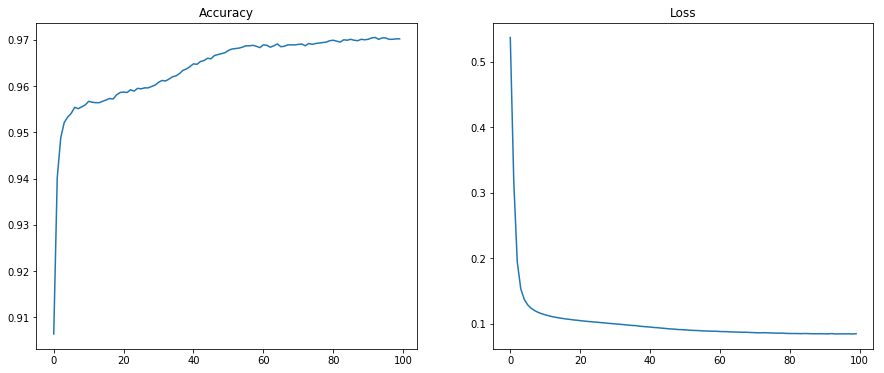

In [158]:
plt.figure(figsize=(15,6))
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(model.history.history['val_acc'])
plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(model.history.history['val_loss'])
plt.title('Loss')
plt.show()

In [159]:
model_6 = model.evaluate(X_test_std, y_test.values.ravel())[1]

958940/958940 [==============================] - 11s 11us/step


In [56]:
# Cross-Val sur Neural Network
# evaluate baseline model with standardized dataset
# estimators = []
# estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasClassifier(build_fn=mlp_func, epochs=20, batch_size=4000, verbose=1)))
# pipeline = Pipeline(estimators)
# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
# results = cross_val_score(pipeline, X_train.iloc[:raw,:].values, y_train.iloc[:raw,:].values.ravel(), cv=kfold)
# print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# Comparaison des modèles

In [160]:
n_model = 6
list_model = [eval(f'model_{i+1}') for i in np.arange(n_model)]
index = [f'model_{i+1}' for i in np.arange(n_model)]
summary = pd.DataFrame(data=list_model, columns=['accuracy'], index=index)
summary.sort_values('accuracy')

,accuracy
model_2,0.946616
model_4,0.965495
model_3,0.968030
model_1,0.970595
model_6,0.971607
model_5,0.972999


# Tunning du modèle XGBoost

In [60]:
n_estimators = 10
raw = 10000

## GridSearch CrossValidation

In [82]:
parameters = {'max_depth':[5,10,15,100], 'learning_rate':[0.1,0.3,0.5,0.66]}
xgb = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=n_estimators)
clf = GridSearchCV(xgb, parameters, cv=3, return_train_score=False)
%time clf.fit(X_train.iloc[:raw,:].values, y_train.iloc[:raw,:].values.ravel(),eval_metric=['error','auc'],\
              verbose=True, eval_set=[(X_test.iloc[:raw,:].values, y_test.iloc[:raw,:].values.ravel())])

[0]	validation_0-error:0.0397	validation_0-auc:0.973532
[1]	validation_0-error:0.0376	validation_0-auc:0.974563
[2]	validation_0-error:0.036	validation_0-auc:0.978053
[3]	validation_0-error:0.0349	validation_0-auc:0.980353
[4]	validation_0-error:0.0356	validation_0-auc:0.980766
[5]	validation_0-error:0.0352	validation_0-auc:0.980801
[6]	validation_0-error:0.0351	validation_0-auc:0.981573
[7]	validation_0-error:0.0339	validation_0-auc:0.981903
[8]	validation_0-error:0.0337	validation_0-auc:0.984629
[9]	validation_0-error:0.033	validation_0-auc:0.986357
[10]	validation_0-error:0.0326	validation_0-auc:0.987526
[11]	validation_0-error:0.0319	validation_0-auc:0.987758
[12]	validation_0-error:0.0314	validation_0-auc:0.987915
[13]	validation_0-error:0.0316	validation_0-auc:0.988749
[14]	validation_0-error:0.031	validation_0-auc:0.988815
[15]	validation_0-error:0.0313	validation_0-auc:0.988944
[16]	validation_0-error:0.0308	validation_0-auc:0.988889
[17]	validation_0-error:0.0311	validation_0-

[45]	validation_0-error:0.0287	validation_0-auc:0.992424
[46]	validation_0-error:0.0287	validation_0-auc:0.992497
[47]	validation_0-error:0.0285	validation_0-auc:0.992656
[48]	validation_0-error:0.0283	validation_0-auc:0.992793
[49]	validation_0-error:0.0282	validation_0-auc:0.992855
[50]	validation_0-error:0.0283	validation_0-auc:0.992889
[51]	validation_0-error:0.0283	validation_0-auc:0.9929
[52]	validation_0-error:0.0281	validation_0-auc:0.993121
[53]	validation_0-error:0.0281	validation_0-auc:0.993151
[54]	validation_0-error:0.0283	validation_0-auc:0.993145
[55]	validation_0-error:0.028	validation_0-auc:0.993143
[56]	validation_0-error:0.0278	validation_0-auc:0.993349
[57]	validation_0-error:0.0276	validation_0-auc:0.993361
[58]	validation_0-error:0.0278	validation_0-auc:0.993371
[59]	validation_0-error:0.0278	validation_0-auc:0.993386
[60]	validation_0-error:0.028	validation_0-auc:0.993419
[61]	validation_0-error:0.0279	validation_0-auc:0.993507
[62]	validation_0-error:0.028	valid

[90]	validation_0-error:0.0252	validation_0-auc:0.995263
[91]	validation_0-error:0.0253	validation_0-auc:0.995255
[92]	validation_0-error:0.0252	validation_0-auc:0.995268
[93]	validation_0-error:0.0252	validation_0-auc:0.995261
[94]	validation_0-error:0.0251	validation_0-auc:0.995265
[95]	validation_0-error:0.0251	validation_0-auc:0.995276
[96]	validation_0-error:0.0248	validation_0-auc:0.995301
[97]	validation_0-error:0.0249	validation_0-auc:0.995323
[98]	validation_0-error:0.025	validation_0-auc:0.99531
[99]	validation_0-error:0.025	validation_0-auc:0.995297
[0]	validation_0-error:0.0408	validation_0-auc:0.976052
[1]	validation_0-error:0.0379	validation_0-auc:0.980932
[2]	validation_0-error:0.0357	validation_0-auc:0.98331
[3]	validation_0-error:0.0343	validation_0-auc:0.985172
[4]	validation_0-error:0.0346	validation_0-auc:0.986911
[5]	validation_0-error:0.0335	validation_0-auc:0.987228
[6]	validation_0-error:0.033	validation_0-auc:0.987105
[7]	validation_0-error:0.0334	validation_0-

[35]	validation_0-error:0.0275	validation_0-auc:0.991459
[36]	validation_0-error:0.0274	validation_0-auc:0.991507
[37]	validation_0-error:0.0275	validation_0-auc:0.991725
[38]	validation_0-error:0.0277	validation_0-auc:0.991738
[39]	validation_0-error:0.0276	validation_0-auc:0.991788
[40]	validation_0-error:0.0275	validation_0-auc:0.991919
[41]	validation_0-error:0.0273	validation_0-auc:0.991944
[42]	validation_0-error:0.0275	validation_0-auc:0.992365
[43]	validation_0-error:0.0274	validation_0-auc:0.992473
[44]	validation_0-error:0.0276	validation_0-auc:0.992544
[45]	validation_0-error:0.0274	validation_0-auc:0.992709
[46]	validation_0-error:0.0273	validation_0-auc:0.992724
[47]	validation_0-error:0.0273	validation_0-auc:0.992777
[48]	validation_0-error:0.0273	validation_0-auc:0.993025
[49]	validation_0-error:0.0268	validation_0-auc:0.993173
[50]	validation_0-error:0.0269	validation_0-auc:0.993361
[51]	validation_0-error:0.0271	validation_0-auc:0.993386
[52]	validation_0-error:0.0275	

[80]	validation_0-error:0.0263	validation_0-auc:0.995438
[81]	validation_0-error:0.0262	validation_0-auc:0.995486
[82]	validation_0-error:0.0264	validation_0-auc:0.995483
[83]	validation_0-error:0.0262	validation_0-auc:0.995484
[84]	validation_0-error:0.0262	validation_0-auc:0.995496
[85]	validation_0-error:0.026	validation_0-auc:0.995534
[86]	validation_0-error:0.0262	validation_0-auc:0.995538
[87]	validation_0-error:0.0259	validation_0-auc:0.995538
[88]	validation_0-error:0.0262	validation_0-auc:0.99554
[89]	validation_0-error:0.0262	validation_0-auc:0.995555
[90]	validation_0-error:0.0261	validation_0-auc:0.995546
[91]	validation_0-error:0.026	validation_0-auc:0.995561
[92]	validation_0-error:0.0261	validation_0-auc:0.995542
[93]	validation_0-error:0.0259	validation_0-auc:0.995546
[94]	validation_0-error:0.0259	validation_0-auc:0.995573
[95]	validation_0-error:0.0259	validation_0-auc:0.995611
[96]	validation_0-error:0.0259	validation_0-auc:0.995639
[97]	validation_0-error:0.0259	val

[25]	validation_0-error:0.0284	validation_0-auc:0.989636
[26]	validation_0-error:0.0278	validation_0-auc:0.98971
[27]	validation_0-error:0.0271	validation_0-auc:0.989926
[28]	validation_0-error:0.0271	validation_0-auc:0.990051
[29]	validation_0-error:0.0272	validation_0-auc:0.990169
[30]	validation_0-error:0.0273	validation_0-auc:0.990811
[31]	validation_0-error:0.0273	validation_0-auc:0.990853
[32]	validation_0-error:0.0269	validation_0-auc:0.990885
[33]	validation_0-error:0.0271	validation_0-auc:0.990978
[34]	validation_0-error:0.0271	validation_0-auc:0.991139
[35]	validation_0-error:0.0272	validation_0-auc:0.991334
[36]	validation_0-error:0.027	validation_0-auc:0.99141
[37]	validation_0-error:0.0269	validation_0-auc:0.991495
[38]	validation_0-error:0.0271	validation_0-auc:0.991726
[39]	validation_0-error:0.0272	validation_0-auc:0.991864
[40]	validation_0-error:0.0272	validation_0-auc:0.99197
[41]	validation_0-error:0.0274	validation_0-auc:0.992023
[42]	validation_0-error:0.0274	vali

[70]	validation_0-error:0.0266	validation_0-auc:0.995339
[71]	validation_0-error:0.0266	validation_0-auc:0.995357
[72]	validation_0-error:0.0268	validation_0-auc:0.995351
[73]	validation_0-error:0.0267	validation_0-auc:0.995368
[74]	validation_0-error:0.0266	validation_0-auc:0.995347
[75]	validation_0-error:0.0267	validation_0-auc:0.995352
[76]	validation_0-error:0.0268	validation_0-auc:0.995361
[77]	validation_0-error:0.0266	validation_0-auc:0.995395
[78]	validation_0-error:0.0264	validation_0-auc:0.995427
[79]	validation_0-error:0.0266	validation_0-auc:0.995434
[80]	validation_0-error:0.0265	validation_0-auc:0.995466
[81]	validation_0-error:0.0266	validation_0-auc:0.995486
[82]	validation_0-error:0.0262	validation_0-auc:0.995475
[83]	validation_0-error:0.0264	validation_0-auc:0.995473
[84]	validation_0-error:0.0262	validation_0-auc:0.995456
[85]	validation_0-error:0.0263	validation_0-auc:0.995453
[86]	validation_0-error:0.0265	validation_0-auc:0.995475
[87]	validation_0-error:0.0265	

[15]	validation_0-error:0.0293	validation_0-auc:0.988175
[16]	validation_0-error:0.0291	validation_0-auc:0.988211
[17]	validation_0-error:0.0289	validation_0-auc:0.988254
[18]	validation_0-error:0.0292	validation_0-auc:0.988244
[19]	validation_0-error:0.0293	validation_0-auc:0.988876
[20]	validation_0-error:0.0294	validation_0-auc:0.989497
[21]	validation_0-error:0.0292	validation_0-auc:0.990255
[22]	validation_0-error:0.0282	validation_0-auc:0.99045
[23]	validation_0-error:0.028	validation_0-auc:0.990465
[24]	validation_0-error:0.0281	validation_0-auc:0.99045
[25]	validation_0-error:0.0282	validation_0-auc:0.990528
[26]	validation_0-error:0.028	validation_0-auc:0.990655
[27]	validation_0-error:0.0279	validation_0-auc:0.990756
[28]	validation_0-error:0.0279	validation_0-auc:0.990901
[29]	validation_0-error:0.028	validation_0-auc:0.991006
[30]	validation_0-error:0.0281	validation_0-auc:0.991059
[31]	validation_0-error:0.0282	validation_0-auc:0.991133
[32]	validation_0-error:0.0284	valid

[60]	validation_0-error:0.0273	validation_0-auc:0.995304
[61]	validation_0-error:0.0273	validation_0-auc:0.995311
[62]	validation_0-error:0.0271	validation_0-auc:0.995298
[63]	validation_0-error:0.027	validation_0-auc:0.995284
[64]	validation_0-error:0.0269	validation_0-auc:0.995275
[65]	validation_0-error:0.0269	validation_0-auc:0.995265
[66]	validation_0-error:0.0269	validation_0-auc:0.995267
[67]	validation_0-error:0.0269	validation_0-auc:0.995259
[68]	validation_0-error:0.0268	validation_0-auc:0.995261
[69]	validation_0-error:0.0268	validation_0-auc:0.995254
[70]	validation_0-error:0.0269	validation_0-auc:0.995253
[71]	validation_0-error:0.0267	validation_0-auc:0.995243
[72]	validation_0-error:0.0266	validation_0-auc:0.995253
[73]	validation_0-error:0.0266	validation_0-auc:0.995245
[74]	validation_0-error:0.0266	validation_0-auc:0.995235
[75]	validation_0-error:0.0265	validation_0-auc:0.995245
[76]	validation_0-error:0.0267	validation_0-auc:0.995288
[77]	validation_0-error:0.0265	v

[5]	validation_0-error:0.0324	validation_0-auc:0.985496
[6]	validation_0-error:0.0325	validation_0-auc:0.986012
[7]	validation_0-error:0.0317	validation_0-auc:0.986474
[8]	validation_0-error:0.0317	validation_0-auc:0.987007
[9]	validation_0-error:0.0318	validation_0-auc:0.988247
[10]	validation_0-error:0.0303	validation_0-auc:0.988997
[11]	validation_0-error:0.0301	validation_0-auc:0.989195
[12]	validation_0-error:0.0294	validation_0-auc:0.991315
[13]	validation_0-error:0.0289	validation_0-auc:0.991836
[14]	validation_0-error:0.0283	validation_0-auc:0.991812
[15]	validation_0-error:0.0283	validation_0-auc:0.992307
[16]	validation_0-error:0.0279	validation_0-auc:0.992623
[17]	validation_0-error:0.0278	validation_0-auc:0.992768
[18]	validation_0-error:0.0279	validation_0-auc:0.992921
[19]	validation_0-error:0.0273	validation_0-auc:0.993409
[20]	validation_0-error:0.0274	validation_0-auc:0.993549
[21]	validation_0-error:0.028	validation_0-auc:0.993522
[22]	validation_0-error:0.0274	valida

[50]	validation_0-error:0.0245	validation_0-auc:0.995407
[51]	validation_0-error:0.0242	validation_0-auc:0.995364
[52]	validation_0-error:0.0245	validation_0-auc:0.995371
[53]	validation_0-error:0.0241	validation_0-auc:0.995385
[54]	validation_0-error:0.0239	validation_0-auc:0.995403
[55]	validation_0-error:0.024	validation_0-auc:0.995404
[56]	validation_0-error:0.0238	validation_0-auc:0.995438
[57]	validation_0-error:0.0238	validation_0-auc:0.995442
[58]	validation_0-error:0.0237	validation_0-auc:0.995512
[59]	validation_0-error:0.0238	validation_0-auc:0.99556
[60]	validation_0-error:0.0237	validation_0-auc:0.995579
[61]	validation_0-error:0.0235	validation_0-auc:0.995613
[62]	validation_0-error:0.024	validation_0-auc:0.995625
[63]	validation_0-error:0.0241	validation_0-auc:0.995647
[64]	validation_0-error:0.0238	validation_0-auc:0.99567
[65]	validation_0-error:0.0239	validation_0-auc:0.995666
[66]	validation_0-error:0.0238	validation_0-auc:0.995589
[67]	validation_0-error:0.0241	vali

[95]	validation_0-error:0.0248	validation_0-auc:0.995745
[96]	validation_0-error:0.025	validation_0-auc:0.995766
[97]	validation_0-error:0.0249	validation_0-auc:0.995763
[98]	validation_0-error:0.0249	validation_0-auc:0.995764
[99]	validation_0-error:0.0249	validation_0-auc:0.99576
[0]	validation_0-error:0.0395	validation_0-auc:0.980389
[1]	validation_0-error:0.0337	validation_0-auc:0.984106
[2]	validation_0-error:0.0317	validation_0-auc:0.98551
[3]	validation_0-error:0.0298	validation_0-auc:0.987152
[4]	validation_0-error:0.0306	validation_0-auc:0.987465
[5]	validation_0-error:0.0305	validation_0-auc:0.987666
[6]	validation_0-error:0.0296	validation_0-auc:0.987824
[7]	validation_0-error:0.0288	validation_0-auc:0.988415
[8]	validation_0-error:0.0292	validation_0-auc:0.989124
[9]	validation_0-error:0.0286	validation_0-auc:0.990411
[10]	validation_0-error:0.0289	validation_0-auc:0.990477
[11]	validation_0-error:0.0281	validation_0-auc:0.991097
[12]	validation_0-error:0.028	validation_0-a

[40]	validation_0-error:0.0267	validation_0-auc:0.99545
[41]	validation_0-error:0.0265	validation_0-auc:0.995483
[42]	validation_0-error:0.0265	validation_0-auc:0.995493
[43]	validation_0-error:0.0262	validation_0-auc:0.995489
[44]	validation_0-error:0.0263	validation_0-auc:0.995529
[45]	validation_0-error:0.0264	validation_0-auc:0.995506
[46]	validation_0-error:0.0264	validation_0-auc:0.995519
[47]	validation_0-error:0.0264	validation_0-auc:0.995542
[48]	validation_0-error:0.0261	validation_0-auc:0.995573
[49]	validation_0-error:0.0262	validation_0-auc:0.995597
[50]	validation_0-error:0.0259	validation_0-auc:0.995598
[51]	validation_0-error:0.0259	validation_0-auc:0.99558
[52]	validation_0-error:0.0258	validation_0-auc:0.995583
[53]	validation_0-error:0.0257	validation_0-auc:0.995615
[54]	validation_0-error:0.0256	validation_0-auc:0.995616
[55]	validation_0-error:0.0256	validation_0-auc:0.995646
[56]	validation_0-error:0.0257	validation_0-auc:0.995657
[57]	validation_0-error:0.0256	va

[85]	validation_0-error:0.0251	validation_0-auc:0.995709
[86]	validation_0-error:0.0252	validation_0-auc:0.995724
[87]	validation_0-error:0.0252	validation_0-auc:0.99573
[88]	validation_0-error:0.0255	validation_0-auc:0.995747
[89]	validation_0-error:0.0256	validation_0-auc:0.995759
[90]	validation_0-error:0.0254	validation_0-auc:0.995752
[91]	validation_0-error:0.0255	validation_0-auc:0.995742
[92]	validation_0-error:0.0255	validation_0-auc:0.995735
[93]	validation_0-error:0.0255	validation_0-auc:0.995718
[94]	validation_0-error:0.0255	validation_0-auc:0.995718
[95]	validation_0-error:0.0256	validation_0-auc:0.995712
[96]	validation_0-error:0.0256	validation_0-auc:0.99571
[97]	validation_0-error:0.0254	validation_0-auc:0.995712
[98]	validation_0-error:0.0253	validation_0-auc:0.995725
[99]	validation_0-error:0.0253	validation_0-auc:0.995729
[0]	validation_0-error:0.0391	validation_0-auc:0.980402
[1]	validation_0-error:0.0333	validation_0-auc:0.984059
[2]	validation_0-error:0.0316	valid

[30]	validation_0-error:0.0263	validation_0-auc:0.99548
[31]	validation_0-error:0.0263	validation_0-auc:0.995466
[32]	validation_0-error:0.026	validation_0-auc:0.995452
[33]	validation_0-error:0.0259	validation_0-auc:0.995433
[34]	validation_0-error:0.0258	validation_0-auc:0.995493
[35]	validation_0-error:0.0256	validation_0-auc:0.995538
[36]	validation_0-error:0.0255	validation_0-auc:0.995535
[37]	validation_0-error:0.0253	validation_0-auc:0.995543
[38]	validation_0-error:0.0255	validation_0-auc:0.995548
[39]	validation_0-error:0.0253	validation_0-auc:0.995524
[40]	validation_0-error:0.0254	validation_0-auc:0.995518
[41]	validation_0-error:0.0253	validation_0-auc:0.995493
[42]	validation_0-error:0.0253	validation_0-auc:0.995547
[43]	validation_0-error:0.0253	validation_0-auc:0.995566
[44]	validation_0-error:0.0248	validation_0-auc:0.995627
[45]	validation_0-error:0.025	validation_0-auc:0.995581
[46]	validation_0-error:0.0247	validation_0-auc:0.995616
[47]	validation_0-error:0.0248	val

[75]	validation_0-error:0.0253	validation_0-auc:0.995663
[76]	validation_0-error:0.025	validation_0-auc:0.995671
[77]	validation_0-error:0.0252	validation_0-auc:0.995649
[78]	validation_0-error:0.0251	validation_0-auc:0.995651
[79]	validation_0-error:0.0251	validation_0-auc:0.995645
[80]	validation_0-error:0.025	validation_0-auc:0.99562
[81]	validation_0-error:0.0251	validation_0-auc:0.995617
[82]	validation_0-error:0.0253	validation_0-auc:0.995613
[83]	validation_0-error:0.0251	validation_0-auc:0.995634
[84]	validation_0-error:0.025	validation_0-auc:0.995639
[85]	validation_0-error:0.025	validation_0-auc:0.995621
[86]	validation_0-error:0.0252	validation_0-auc:0.995634
[87]	validation_0-error:0.0251	validation_0-auc:0.99561
[88]	validation_0-error:0.0253	validation_0-auc:0.995599
[89]	validation_0-error:0.0252	validation_0-auc:0.995588
[90]	validation_0-error:0.0251	validation_0-auc:0.995595
[91]	validation_0-error:0.0254	validation_0-auc:0.9956
[92]	validation_0-error:0.0253	validati

[20]	validation_0-error:0.0282	validation_0-auc:0.99475
[21]	validation_0-error:0.0278	validation_0-auc:0.994846
[22]	validation_0-error:0.0279	validation_0-auc:0.994949
[23]	validation_0-error:0.0276	validation_0-auc:0.994999
[24]	validation_0-error:0.0274	validation_0-auc:0.995022
[25]	validation_0-error:0.0275	validation_0-auc:0.995104
[26]	validation_0-error:0.0273	validation_0-auc:0.995223
[27]	validation_0-error:0.0265	validation_0-auc:0.995308
[28]	validation_0-error:0.0268	validation_0-auc:0.995295
[29]	validation_0-error:0.0265	validation_0-auc:0.995358
[30]	validation_0-error:0.0268	validation_0-auc:0.99532
[31]	validation_0-error:0.0267	validation_0-auc:0.995376
[32]	validation_0-error:0.0266	validation_0-auc:0.995389
[33]	validation_0-error:0.0267	validation_0-auc:0.995449
[34]	validation_0-error:0.0266	validation_0-auc:0.99541
[35]	validation_0-error:0.0266	validation_0-auc:0.995445
[36]	validation_0-error:0.0259	validation_0-auc:0.995516
[37]	validation_0-error:0.026	vali

[65]	validation_0-error:0.0255	validation_0-auc:0.995298
[66]	validation_0-error:0.0254	validation_0-auc:0.995284
[67]	validation_0-error:0.0254	validation_0-auc:0.995259
[68]	validation_0-error:0.0255	validation_0-auc:0.995205
[69]	validation_0-error:0.0256	validation_0-auc:0.995219
[70]	validation_0-error:0.0255	validation_0-auc:0.99524
[71]	validation_0-error:0.0257	validation_0-auc:0.995241
[72]	validation_0-error:0.0254	validation_0-auc:0.995216
[73]	validation_0-error:0.026	validation_0-auc:0.995243
[74]	validation_0-error:0.026	validation_0-auc:0.995279
[75]	validation_0-error:0.0258	validation_0-auc:0.995267
[76]	validation_0-error:0.026	validation_0-auc:0.995251
[77]	validation_0-error:0.0259	validation_0-auc:0.995238
[78]	validation_0-error:0.0258	validation_0-auc:0.995236
[79]	validation_0-error:0.0259	validation_0-auc:0.995215
[80]	validation_0-error:0.026	validation_0-auc:0.995209
[81]	validation_0-error:0.0261	validation_0-auc:0.995224
[82]	validation_0-error:0.0263	valid

[10]	validation_0-error:0.0285	validation_0-auc:0.993756
[11]	validation_0-error:0.0287	validation_0-auc:0.994078
[12]	validation_0-error:0.028	validation_0-auc:0.994474
[13]	validation_0-error:0.0276	validation_0-auc:0.994536
[14]	validation_0-error:0.0271	validation_0-auc:0.994421
[15]	validation_0-error:0.0285	validation_0-auc:0.994398
[16]	validation_0-error:0.0274	validation_0-auc:0.994367
[17]	validation_0-error:0.0277	validation_0-auc:0.994508
[18]	validation_0-error:0.0279	validation_0-auc:0.994423
[19]	validation_0-error:0.0275	validation_0-auc:0.994609
[20]	validation_0-error:0.028	validation_0-auc:0.994678
[21]	validation_0-error:0.0276	validation_0-auc:0.994748
[22]	validation_0-error:0.027	validation_0-auc:0.994806
[23]	validation_0-error:0.0269	validation_0-auc:0.994828
[24]	validation_0-error:0.0266	validation_0-auc:0.994844
[25]	validation_0-error:0.0267	validation_0-auc:0.9949
[26]	validation_0-error:0.0269	validation_0-auc:0.994952
[27]	validation_0-error:0.0264	valid

[55]	validation_0-error:0.0272	validation_0-auc:0.995111
[56]	validation_0-error:0.0274	validation_0-auc:0.995104
[57]	validation_0-error:0.0273	validation_0-auc:0.99513
[58]	validation_0-error:0.0275	validation_0-auc:0.995114
[59]	validation_0-error:0.0277	validation_0-auc:0.995117
[60]	validation_0-error:0.0275	validation_0-auc:0.995148
[61]	validation_0-error:0.0274	validation_0-auc:0.995142
[62]	validation_0-error:0.0273	validation_0-auc:0.995168
[63]	validation_0-error:0.0273	validation_0-auc:0.995192
[64]	validation_0-error:0.0273	validation_0-auc:0.995195
[65]	validation_0-error:0.0273	validation_0-auc:0.9952
[66]	validation_0-error:0.0271	validation_0-auc:0.995205
[67]	validation_0-error:0.0272	validation_0-auc:0.995221
[68]	validation_0-error:0.0271	validation_0-auc:0.995241
[69]	validation_0-error:0.027	validation_0-auc:0.995271
[70]	validation_0-error:0.0272	validation_0-auc:0.995256
[71]	validation_0-error:0.0272	validation_0-auc:0.995247
[72]	validation_0-error:0.0271	vali

[0]	validation_0-error:0.0399	validation_0-auc:0.979813
[1]	validation_0-error:0.0358	validation_0-auc:0.984262
[2]	validation_0-error:0.0335	validation_0-auc:0.987048
[3]	validation_0-error:0.0332	validation_0-auc:0.988346
[4]	validation_0-error:0.0319	validation_0-auc:0.988937
[5]	validation_0-error:0.0307	validation_0-auc:0.989652
[6]	validation_0-error:0.0303	validation_0-auc:0.9909
[7]	validation_0-error:0.0305	validation_0-auc:0.991804
[8]	validation_0-error:0.0297	validation_0-auc:0.991993
[9]	validation_0-error:0.0299	validation_0-auc:0.992597
[10]	validation_0-error:0.0293	validation_0-auc:0.992906
[11]	validation_0-error:0.0283	validation_0-auc:0.993164
[12]	validation_0-error:0.0286	validation_0-auc:0.993367
[13]	validation_0-error:0.0283	validation_0-auc:0.993539
[14]	validation_0-error:0.0282	validation_0-auc:0.993926
[15]	validation_0-error:0.0279	validation_0-auc:0.994019
[16]	validation_0-error:0.0273	validation_0-auc:0.994189
[17]	validation_0-error:0.0273	validation_0

[45]	validation_0-error:0.0265	validation_0-auc:0.995239
[46]	validation_0-error:0.0268	validation_0-auc:0.995292
[47]	validation_0-error:0.0268	validation_0-auc:0.995334
[48]	validation_0-error:0.0266	validation_0-auc:0.995323
[49]	validation_0-error:0.0265	validation_0-auc:0.995283
[50]	validation_0-error:0.0264	validation_0-auc:0.995268
[51]	validation_0-error:0.0266	validation_0-auc:0.995266
[52]	validation_0-error:0.0266	validation_0-auc:0.995267
[53]	validation_0-error:0.0265	validation_0-auc:0.995259
[54]	validation_0-error:0.0263	validation_0-auc:0.995299
[55]	validation_0-error:0.0263	validation_0-auc:0.995263
[56]	validation_0-error:0.0263	validation_0-auc:0.995287
[57]	validation_0-error:0.0264	validation_0-auc:0.995279
[58]	validation_0-error:0.0265	validation_0-auc:0.995225
[59]	validation_0-error:0.0266	validation_0-auc:0.995208
[60]	validation_0-error:0.0264	validation_0-auc:0.995203
[61]	validation_0-error:0.0262	validation_0-auc:0.995223
[62]	validation_0-error:0.0263	

[90]	validation_0-error:0.0246	validation_0-auc:0.995105
[91]	validation_0-error:0.0244	validation_0-auc:0.995124
[92]	validation_0-error:0.0245	validation_0-auc:0.995114
[93]	validation_0-error:0.0249	validation_0-auc:0.99511
[94]	validation_0-error:0.0245	validation_0-auc:0.99511
[95]	validation_0-error:0.0245	validation_0-auc:0.995119
[96]	validation_0-error:0.0244	validation_0-auc:0.995121
[97]	validation_0-error:0.0243	validation_0-auc:0.995121
[98]	validation_0-error:0.0243	validation_0-auc:0.995107
[99]	validation_0-error:0.0244	validation_0-auc:0.995106
[0]	validation_0-error:0.0403	validation_0-auc:0.979845
[1]	validation_0-error:0.0365	validation_0-auc:0.981798
[2]	validation_0-error:0.0327	validation_0-auc:0.986023
[3]	validation_0-error:0.0317	validation_0-auc:0.988244
[4]	validation_0-error:0.0307	validation_0-auc:0.989895
[5]	validation_0-error:0.0294	validation_0-auc:0.990795
[6]	validation_0-error:0.0286	validation_0-auc:0.992447
[7]	validation_0-error:0.0286	validation

[35]	validation_0-error:0.0258	validation_0-auc:0.995845
[36]	validation_0-error:0.0253	validation_0-auc:0.995865
[37]	validation_0-error:0.0258	validation_0-auc:0.995847
[38]	validation_0-error:0.0256	validation_0-auc:0.995866
[39]	validation_0-error:0.0255	validation_0-auc:0.995815
[40]	validation_0-error:0.0256	validation_0-auc:0.99582
[41]	validation_0-error:0.0255	validation_0-auc:0.995832
[42]	validation_0-error:0.0256	validation_0-auc:0.995844
[43]	validation_0-error:0.0252	validation_0-auc:0.995854
[44]	validation_0-error:0.0255	validation_0-auc:0.995875
[45]	validation_0-error:0.0254	validation_0-auc:0.995922
[46]	validation_0-error:0.0254	validation_0-auc:0.995906
[47]	validation_0-error:0.0256	validation_0-auc:0.995879
[48]	validation_0-error:0.0254	validation_0-auc:0.995879
[49]	validation_0-error:0.0254	validation_0-auc:0.995875
[50]	validation_0-error:0.0258	validation_0-auc:0.995884
[51]	validation_0-error:0.0256	validation_0-auc:0.995877
[52]	validation_0-error:0.0257	v

[80]	validation_0-error:0.0246	validation_0-auc:0.99507
[81]	validation_0-error:0.0244	validation_0-auc:0.995068
[82]	validation_0-error:0.0246	validation_0-auc:0.995069
[83]	validation_0-error:0.0246	validation_0-auc:0.995061
[84]	validation_0-error:0.0246	validation_0-auc:0.995055
[85]	validation_0-error:0.0247	validation_0-auc:0.995037
[86]	validation_0-error:0.0247	validation_0-auc:0.995063
[87]	validation_0-error:0.0246	validation_0-auc:0.99507
[88]	validation_0-error:0.0247	validation_0-auc:0.99506
[89]	validation_0-error:0.0248	validation_0-auc:0.99507
[90]	validation_0-error:0.0246	validation_0-auc:0.99509
[91]	validation_0-error:0.0246	validation_0-auc:0.99508
[92]	validation_0-error:0.0246	validation_0-auc:0.995111
[93]	validation_0-error:0.0246	validation_0-auc:0.995106
[94]	validation_0-error:0.0249	validation_0-auc:0.995094
[95]	validation_0-error:0.0247	validation_0-auc:0.995109
[96]	validation_0-error:0.0247	validation_0-auc:0.995121
[97]	validation_0-error:0.0247	valida

[25]	validation_0-error:0.0288	validation_0-auc:0.994342
[26]	validation_0-error:0.0283	validation_0-auc:0.994502
[27]	validation_0-error:0.028	validation_0-auc:0.994535
[28]	validation_0-error:0.0281	validation_0-auc:0.994544
[29]	validation_0-error:0.0281	validation_0-auc:0.994557
[30]	validation_0-error:0.0283	validation_0-auc:0.994634
[31]	validation_0-error:0.028	validation_0-auc:0.994663
[32]	validation_0-error:0.0282	validation_0-auc:0.994712
[33]	validation_0-error:0.0286	validation_0-auc:0.994699
[34]	validation_0-error:0.0285	validation_0-auc:0.994714
[35]	validation_0-error:0.0278	validation_0-auc:0.994699
[36]	validation_0-error:0.028	validation_0-auc:0.994723
[37]	validation_0-error:0.028	validation_0-auc:0.994824
[38]	validation_0-error:0.0277	validation_0-auc:0.994854
[39]	validation_0-error:0.0274	validation_0-auc:0.994768
[40]	validation_0-error:0.0279	validation_0-auc:0.994781
[41]	validation_0-error:0.0279	validation_0-auc:0.994859
[42]	validation_0-error:0.0275	vali

[70]	validation_0-error:0.0269	validation_0-auc:0.994538
[71]	validation_0-error:0.027	validation_0-auc:0.994558
[72]	validation_0-error:0.0267	validation_0-auc:0.994587
[73]	validation_0-error:0.0269	validation_0-auc:0.994554
[74]	validation_0-error:0.0269	validation_0-auc:0.994557
[75]	validation_0-error:0.0267	validation_0-auc:0.994576
[76]	validation_0-error:0.0268	validation_0-auc:0.994563
[77]	validation_0-error:0.0268	validation_0-auc:0.994571
[78]	validation_0-error:0.0267	validation_0-auc:0.994572
[79]	validation_0-error:0.0266	validation_0-auc:0.994571
[80]	validation_0-error:0.0267	validation_0-auc:0.994578
[81]	validation_0-error:0.0269	validation_0-auc:0.994574
[82]	validation_0-error:0.0266	validation_0-auc:0.994582
[83]	validation_0-error:0.0268	validation_0-auc:0.994591
[84]	validation_0-error:0.0265	validation_0-auc:0.99461
[85]	validation_0-error:0.0266	validation_0-auc:0.994588
[86]	validation_0-error:0.0268	validation_0-auc:0.994569
[87]	validation_0-error:0.0267	va

[15]	validation_0-error:0.0272	validation_0-auc:0.994073
[16]	validation_0-error:0.0273	validation_0-auc:0.994079
[17]	validation_0-error:0.0272	validation_0-auc:0.994236
[18]	validation_0-error:0.0276	validation_0-auc:0.994267
[19]	validation_0-error:0.0268	validation_0-auc:0.994375
[20]	validation_0-error:0.0264	validation_0-auc:0.99455
[21]	validation_0-error:0.0266	validation_0-auc:0.994641
[22]	validation_0-error:0.0267	validation_0-auc:0.994634
[23]	validation_0-error:0.0269	validation_0-auc:0.994667
[24]	validation_0-error:0.0267	validation_0-auc:0.994726
[25]	validation_0-error:0.0273	validation_0-auc:0.994729
[26]	validation_0-error:0.0266	validation_0-auc:0.994829
[27]	validation_0-error:0.0264	validation_0-auc:0.994795
[28]	validation_0-error:0.0265	validation_0-auc:0.99481
[29]	validation_0-error:0.0265	validation_0-auc:0.994796
[30]	validation_0-error:0.0263	validation_0-auc:0.994885
[31]	validation_0-error:0.0262	validation_0-auc:0.994956
[32]	validation_0-error:0.026	val

[60]	validation_0-error:0.0259	validation_0-auc:0.994879
[61]	validation_0-error:0.026	validation_0-auc:0.994879
[62]	validation_0-error:0.0261	validation_0-auc:0.994925
[63]	validation_0-error:0.0259	validation_0-auc:0.994925
[64]	validation_0-error:0.0258	validation_0-auc:0.994916
[65]	validation_0-error:0.0258	validation_0-auc:0.994921
[66]	validation_0-error:0.026	validation_0-auc:0.994907
[67]	validation_0-error:0.026	validation_0-auc:0.994926
[68]	validation_0-error:0.0259	validation_0-auc:0.994924
[69]	validation_0-error:0.0257	validation_0-auc:0.994942
[70]	validation_0-error:0.0258	validation_0-auc:0.994963
[71]	validation_0-error:0.0259	validation_0-auc:0.994961
[72]	validation_0-error:0.0258	validation_0-auc:0.994963
[73]	validation_0-error:0.0256	validation_0-auc:0.994979
[74]	validation_0-error:0.0255	validation_0-auc:0.994986
[75]	validation_0-error:0.0256	validation_0-auc:0.995018
[76]	validation_0-error:0.0257	validation_0-auc:0.995034
[77]	validation_0-error:0.0258	val

[5]	validation_0-error:0.0307	validation_0-auc:0.99076
[6]	validation_0-error:0.029	validation_0-auc:0.991614
[7]	validation_0-error:0.0292	validation_0-auc:0.99205
[8]	validation_0-error:0.0287	validation_0-auc:0.992995
[9]	validation_0-error:0.0287	validation_0-auc:0.993142
[10]	validation_0-error:0.0284	validation_0-auc:0.993255
[11]	validation_0-error:0.0285	validation_0-auc:0.993279
[12]	validation_0-error:0.0283	validation_0-auc:0.99363
[13]	validation_0-error:0.0277	validation_0-auc:0.993782
[14]	validation_0-error:0.0271	validation_0-auc:0.993725
[15]	validation_0-error:0.0271	validation_0-auc:0.993797
[16]	validation_0-error:0.0275	validation_0-auc:0.993837
[17]	validation_0-error:0.0268	validation_0-auc:0.994125
[18]	validation_0-error:0.0273	validation_0-auc:0.994185
[19]	validation_0-error:0.0273	validation_0-auc:0.994306
[20]	validation_0-error:0.0273	validation_0-auc:0.994281
[21]	validation_0-error:0.0273	validation_0-auc:0.994299
[22]	validation_0-error:0.0274	validatio

[50]	validation_0-error:0.0261	validation_0-auc:0.99478
[51]	validation_0-error:0.026	validation_0-auc:0.994751
[52]	validation_0-error:0.0258	validation_0-auc:0.994726
[53]	validation_0-error:0.026	validation_0-auc:0.994751
[54]	validation_0-error:0.0259	validation_0-auc:0.99474
[55]	validation_0-error:0.0255	validation_0-auc:0.994788
[56]	validation_0-error:0.0259	validation_0-auc:0.994808
[57]	validation_0-error:0.0262	validation_0-auc:0.994798
[58]	validation_0-error:0.0259	validation_0-auc:0.994803
[59]	validation_0-error:0.0259	validation_0-auc:0.994805
[60]	validation_0-error:0.0258	validation_0-auc:0.994817
[61]	validation_0-error:0.0256	validation_0-auc:0.994814
[62]	validation_0-error:0.0258	validation_0-auc:0.994818
[63]	validation_0-error:0.0258	validation_0-auc:0.994821
[64]	validation_0-error:0.0259	validation_0-auc:0.994798
[65]	validation_0-error:0.0262	validation_0-auc:0.994785
[66]	validation_0-error:0.0262	validation_0-auc:0.994789
[67]	validation_0-error:0.0261	vali

[95]	validation_0-error:0.0242	validation_0-auc:0.995575
[96]	validation_0-error:0.0241	validation_0-auc:0.995574
[97]	validation_0-error:0.024	validation_0-auc:0.995572
[98]	validation_0-error:0.0241	validation_0-auc:0.99558
[99]	validation_0-error:0.0241	validation_0-auc:0.995579
[0]	validation_0-error:0.041	validation_0-auc:0.976045
[1]	validation_0-error:0.0382	validation_0-auc:0.982767
[2]	validation_0-error:0.0345	validation_0-auc:0.985349
[3]	validation_0-error:0.0338	validation_0-auc:0.988757
[4]	validation_0-error:0.0319	validation_0-auc:0.990071
[5]	validation_0-error:0.0314	validation_0-auc:0.990602
[6]	validation_0-error:0.0304	validation_0-auc:0.991329
[7]	validation_0-error:0.0297	validation_0-auc:0.991651
[8]	validation_0-error:0.0299	validation_0-auc:0.992046
[9]	validation_0-error:0.029	validation_0-auc:0.992237
[10]	validation_0-error:0.0287	validation_0-auc:0.992688
[11]	validation_0-error:0.0288	validation_0-auc:0.993004
[12]	validation_0-error:0.0288	validation_0-a

[40]	validation_0-error:0.0264	validation_0-auc:0.994734
[41]	validation_0-error:0.026	validation_0-auc:0.994751
[42]	validation_0-error:0.0262	validation_0-auc:0.994748
[43]	validation_0-error:0.0263	validation_0-auc:0.994775
[44]	validation_0-error:0.026	validation_0-auc:0.99478
[45]	validation_0-error:0.026	validation_0-auc:0.994815
[46]	validation_0-error:0.026	validation_0-auc:0.994796
[47]	validation_0-error:0.0261	validation_0-auc:0.994797
[48]	validation_0-error:0.026	validation_0-auc:0.994804
[49]	validation_0-error:0.0262	validation_0-auc:0.994805
[50]	validation_0-error:0.0261	validation_0-auc:0.99478
[51]	validation_0-error:0.026	validation_0-auc:0.994751
[52]	validation_0-error:0.0258	validation_0-auc:0.994726
[53]	validation_0-error:0.026	validation_0-auc:0.994751
[54]	validation_0-error:0.0259	validation_0-auc:0.99474
[55]	validation_0-error:0.0255	validation_0-auc:0.994788
[56]	validation_0-error:0.0259	validation_0-auc:0.994808
[57]	validation_0-error:0.0262	validation

[85]	validation_0-error:0.0244	validation_0-auc:0.995579
[86]	validation_0-error:0.0246	validation_0-auc:0.995592
[87]	validation_0-error:0.0246	validation_0-auc:0.995581
[88]	validation_0-error:0.0243	validation_0-auc:0.995585
[89]	validation_0-error:0.0242	validation_0-auc:0.995582
[90]	validation_0-error:0.0244	validation_0-auc:0.9956
[91]	validation_0-error:0.0243	validation_0-auc:0.995602
[92]	validation_0-error:0.0242	validation_0-auc:0.995599
[93]	validation_0-error:0.0242	validation_0-auc:0.995586
[94]	validation_0-error:0.0242	validation_0-auc:0.995586
[95]	validation_0-error:0.0242	validation_0-auc:0.995575
[96]	validation_0-error:0.0241	validation_0-auc:0.995574
[97]	validation_0-error:0.024	validation_0-auc:0.995572
[98]	validation_0-error:0.0241	validation_0-auc:0.99558
[99]	validation_0-error:0.0241	validation_0-auc:0.995579
[0]	validation_0-error:0.0378	validation_0-auc:0.979778
[1]	validation_0-error:0.0344	validation_0-auc:0.984854
[2]	validation_0-error:0.032	validati

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 10, 15, 100], 'learning_rate': [0.1, 0.3, 0.5, 0.66]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=0)

In [96]:
# Meilleurs paramètres retenus:
clf.best_params_

{'learning_rate': 0.3, 'max_depth': 15}

En réalité j'ai testé plus de paramètre mais je ne fais pas tout figurer dans le rapport

In [85]:
# Application avec les paramètres sélèctionnés
n_estimators = 100
raw = 100000
xgb = XGBClassifier(random_state=42, n_jobs=-1, learning_rate=0.66, n_estimators=n_estimators, max_depth=10)
%time xgb.fit(X_train.iloc[:raw,:].values, y_train.iloc[:raw,:].values.ravel(),eval_metric=['error','auc'],\
              verbose=True, eval_set=[(X_test.iloc[:raw,:].values, y_test.iloc[:raw,:].values.ravel())])

[0]	validation_0-error:0.03103	validation_0-auc:0.989155
[1]	validation_0-error:0.02813	validation_0-auc:0.991673
[2]	validation_0-error:0.02628	validation_0-auc:0.993397
[3]	validation_0-error:0.025	validation_0-auc:0.994274
[4]	validation_0-error:0.0244	validation_0-auc:0.994912
[5]	validation_0-error:0.02335	validation_0-auc:0.995533
[6]	validation_0-error:0.0225	validation_0-auc:0.995941
[7]	validation_0-error:0.02201	validation_0-auc:0.996079
[8]	validation_0-error:0.0217	validation_0-auc:0.996338
[9]	validation_0-error:0.02156	validation_0-auc:0.996451
[10]	validation_0-error:0.02133	validation_0-auc:0.996574
[11]	validation_0-error:0.02098	validation_0-auc:0.996703
[12]	validation_0-error:0.02066	validation_0-auc:0.996771
[13]	validation_0-error:0.02075	validation_0-auc:0.996839
[14]	validation_0-error:0.0206	validation_0-auc:0.996927
[15]	validation_0-error:0.02037	validation_0-auc:0.996954
[16]	validation_0-error:0.02034	validation_0-auc:0.997003
[17]	validation_0-error:0.0200

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.66, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

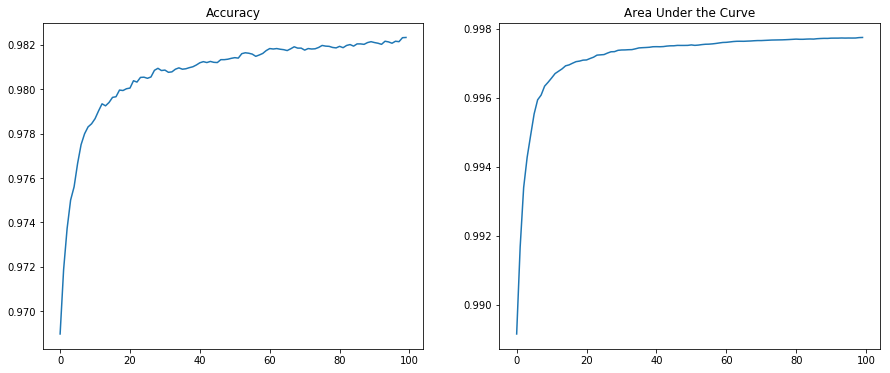

In [86]:
accuracy_list =1-pd.DataFrame(xgb.evals_result_['validation_0']['error'])

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(accuracy_list)
plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(xgb.evals_result_['validation_0']['auc'])
plt.title('Area Under the Curve')
plt.show()

In [87]:
xgb.score(X_test.values, y_test.values.ravel())

0.9827319748889398

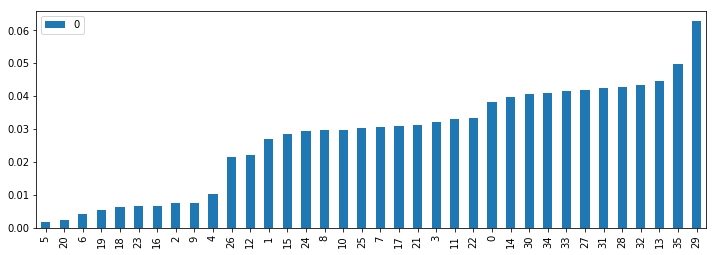

In [97]:
# Importance des features:
pd.DataFrame(xgb.feature_importances_).sort_values(by=0).plot(kind='bar', figsize=(12,4))
plt.show()

## Augmentation des features

In [90]:
leafs_train = pd.DataFrame(xgb.apply(X_train.iloc[:raw,:].values))
leafs_test = pd.DataFrame(xgb.apply(X_test.iloc[:raw,:].values))

In [91]:
X_train_concat = pd.concat(axis=1, objs=[X_train.iloc[:raw,:].reset_index(drop=True),leafs_train])
X_test_concat = pd.concat(axis=1, objs=[X_test.iloc[:raw,:].reset_index(drop=True), leafs_test])

In [92]:
xgb2 = XGBClassifier(random_state=42, n_jobs=-1, learning_rate=0.66, n_estimators=n_estimators, max_depth=10)
%time xgb2.fit(X_train_concat.values, y_train.iloc[:raw,:].values.ravel(),\
               verbose=True, eval_set=[(X_test_concat.values, y_test.iloc[:raw,:].values.ravel())])

[0]	validation_0-error:0.03096
[1]	validation_0-error:0.02865
[2]	validation_0-error:0.02658
[3]	validation_0-error:0.02566
[4]	validation_0-error:0.02482
[5]	validation_0-error:0.02465
[6]	validation_0-error:0.02385
[7]	validation_0-error:0.02351
[8]	validation_0-error:0.02311
[9]	validation_0-error:0.02291
[10]	validation_0-error:0.02234
[11]	validation_0-error:0.02241
[12]	validation_0-error:0.02216
[13]	validation_0-error:0.02193
[14]	validation_0-error:0.02194
[15]	validation_0-error:0.0217
[16]	validation_0-error:0.02146
[17]	validation_0-error:0.02139
[18]	validation_0-error:0.02127
[19]	validation_0-error:0.02103
[20]	validation_0-error:0.02089
[21]	validation_0-error:0.0207
[22]	validation_0-error:0.02065
[23]	validation_0-error:0.02045
[24]	validation_0-error:0.02036
[25]	validation_0-error:0.02037
[26]	validation_0-error:0.02025
[27]	validation_0-error:0.02044
[28]	validation_0-error:0.02033
[29]	validation_0-error:0.0202
[30]	validation_0-error:0.02
[31]	validation_0-error:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.66, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [94]:
xgb2.score(X_test_concat.values, y_test.iloc[:raw,:].values.ravel())

0.98094

Malheureusement l'augmentation des features n'a pas permis d'améliorer le score

In [62]:
# Standardize split data set
scaler = StandardScaler()
X_train_cstd = pd.DataFrame(scaler.fit_transform(X_train_concat))
X_test_cstd = pd.DataFrame(scaler.fit_transform(X_test_concat))

# Ensembling et Stacking

## Ensembling

**Pour plus d'informations sur les methodes d'ensembe et de stacking : https://mlwave.com/kaggle-ensembling-guide/**

L'ensembling consiste à combiner les résultats des différents modèles et faire un vote majoritaire sur ces résultats

In [98]:
# Chargmements des résultats des modèles testés :
model1 = pd.read_csv("model1-XGB1000-09929.csv",header=None)
model2 = pd.read_csv("model2-RF1000-09872.csv",header=None)
model3 = pd.read_csv("model3-ET-09450.csv",header=None)
model4 = pd.read_csv("model4-XGB5000-09910.csv",header=None)
model5 = pd.read_csv("model6-XGB_std_2000.csv",header=None)
model6 = pd.read_csv("model7-GaussianNB.csv",header=None)
model7 = pd.read_csv("model9-MLP.csv",header=None)
model8 = pd.read_csv("model10-RF_small.csv",header=None)
model9 = pd.read_csv("model11-XGB_4k_lr066.csv",header=None)

In [100]:
ensemble_feat = pd.concat(axis=1, objs=[model1,model2,model3,model4,model5,model6,model7,model8,model9],
                          copy=True, sort=False)

In [102]:
ensemble_feat.head(10)

,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1
5,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0
7,1,1,0,1,1,0,1,0,1
8,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0


In [103]:
maj_vote = np.round(decimals=0, a=ensemble_feat.mean(axis=1))

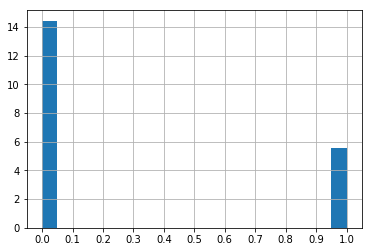

In [104]:
maj_vote.hist(density=True, bins=20)
plt.xticks(np.arange(0,1.1,0.1))
plt.show()

Malheureusement l'ensembling n'a pas amélioré les résultats du meilleur classifeur XGBoost

## Stacking

In [137]:
n_estimators = 50
n_splits = 2
raw = 10000

clf1 = XGBClassifier(n_jobs=-1, learning_rate=0.66, n_estimators=n_estimators, max_depth=10, random_state=seed)
clf2 = GaussianNB()
clf3 = ExtraTreesClassifier(n_jobs=-1, n_estimators=n_estimators, criterion='gini', random_state=seed)
clf4 = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators, criterion='gini', random_state=seed)
clf5 = LogisticRegression(n_jobs=-1,random_state=seed)
meta = XGBClassifier(n_jobs=-1, learning_rate=0.66, n_estimators=n_estimators, max_depth=8, random_state=seed)
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3, clf4, clf5], use_probas=True, average_probas=False, meta_classifier=meta)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, sclf], 
                      ['XGB', 'NB', 'ET', 'RF', 'LR', 'StackingClassifier']):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    scores = model_selection.cross_val_score(clf, Xtrain.iloc[:raw,:].values, ytrain.iloc[:raw,:].values.ravel(), cv=kfold, scoring='accuracy')
    print("Accuracy: %0.4f [%s]" % (scores.mean(), label))

3-fold cross validation:

Accuracy: 0.9695 [XGB]
Accuracy: 0.9457 [NB]
Accuracy: 0.9637 [ET]
Accuracy: 0.9671 [RF]
Accuracy: 0.9448 [LR]
Accuracy: 0.9696 [StackingClassifier]


Le Stacking fonctionne très bien et augmente systématiquement les résultats. Malheureusement, sur un data set de grande taille comme c'est notre cas, cela prend énormément de temps à fiter sur tout le data set et on arrive rapidement à saturation de la mémoire.

# Résultat final

In [ ]:
# Meilleurs résultats obtenus avec ce modèle :
xgb = XGBClassifier(random_state=42, n_jobs=-1, learning_rate=0.66, n_estimators=4000, max_depth=10)
%time xgb.fit(Xtrain.values, ytrain.values.ravel())

## Load Model

In [114]:
import urllib
onedriveURL = "https://1drv.ms/u/s!AuLqJpv9GvE0gcE9PHog68U9J7Gb2A"
copy_onedrive = "XGB_4K_lr066.sav"
urllib.request.urlretrieve(onedriveURL , copy_onedrive)

('XGB_4K.sav', <http.client.HTTPMessage at 0x1ff86c16748>)

In [133]:
# load the model from disk
filename = 'XGB_4K_lr066.sav'
loaded_model = joblib.load(filename)

[02:30:05] d:\build\xgboost\xgboost-0.81.git\src\learner.cc:377: Parameter 'predictor' will be set to 'cpu_predictor' since XGBoots wasn't compiled with GPU support.


## Save Results

In [137]:
# save the model
filename = 'test.sav'
joblib.dump(xgb, filename)

# save the predictin
np.savetxt('test.csv', y_test, fmt='%1.0d', delimiter=',')